In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model_deep import *
from train import *
from types import SimpleNamespace


In [2]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{0}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")

GPU 0: NVIDIA GeForce GTX 1080
Total Memory: 7.9GB
Allocated Memory: 0.0GB
Free Memory: 7.9GB


In [3]:
def anti_vec(vec):
    N = math.ceil(math.sqrt(vec.shape[-1] * 2))
    adj = torch.zeros((vec.shape[0], N, N), dtype=vec.dtype)
    row_idx, col_idx = torch.triu_indices(N, N, offset=1)
    row_idx = (N - 1 - row_idx).flip(dims=[0])
    col_idx = (N - 1 - col_idx).flip(dims=[0])
    adj[:, row_idx, col_idx] = vec
    adj[:, col_idx, row_idx] = vec
    return adj

In [4]:
training_data = np.loadtxt('../lr_train.csv', delimiter=',', skiprows=1)
training_data_adj = anti_vec(torch.from_numpy(training_data))

training_label = np.loadtxt('../hr_train.csv', delimiter=',', skiprows=1)
training_label_adj = anti_vec(torch.from_numpy(training_label))

In [5]:
def get_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    size_mb = (param_size + buffer_size) / (1024**2)  # Convert bytes to MB
    return size_mb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
from types import SimpleNamespace

kf = KFold(n_splits=3, shuffle=True, random_state=42)

n = math.ceil(math.sqrt(training_data.shape[-1] * 2))
n_prime =  math.ceil(math.sqrt(training_label.shape[-1] * 2))

args = {
    "lr_dim": 160,
    "hr_dim": 268,
    "hidden_dim": 268,
    "lr": 0.005,
    "epochs": 100,
    "padding": 26,
    "lmbda": 16,
    "device": device,
    "batch_size": len(training_data) // 10
}
args = SimpleNamespace(**args)
model = PerfectFeatureModel(160, 268)
print(model)
print(f"Model size: {get_model_size(model):.2f} MB")
print(f"Number of trainable parameters: {count_parameters(model):,}")

PerfectFeatureModel(
  (feature_learner): LrFeatureUpScaler(
    (conv1): TransformerConv(160, 67, heads=4)
    (bn1): GraphNorm(268)
    (conv2): TransformerConv(268, 67, heads=8)
    (bn2): GraphNorm(536)
  )
  (upsampler): LrUpsampling(
    (conv1): TransformerConv(160, 50, heads=4)
    (bn1): GraphNorm(200)
    (conv2): TransformerConv(200, 67, heads=4)
    (bn2): GraphNorm(268)
  )
)
Model size: 4.19 MB
Number of trainable parameters: 1,098,220


In [18]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
model_index = 0
for train_index, val_index in kf.split(training_data_adj):
    # new model for each fold
    model = PerfectFeatureModel(n, n_prime).to(args.device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    X_train, X_val = training_data_adj[train_index], training_data_adj[val_index]
    Y_train, Y_val = training_label_adj[train_index], training_label_adj[val_index]
    train(model, optimizer, X_train, Y_train, X_val, Y_val, f"./model_{model_index}", args)
    model_index += 1

  0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 111/111 [00:05<00:00, 21.77it/s]


Epoch 1/100, Train Loss: 0.10387083515524864, Reconstruction Loss: 0.02314260024745185, Prediction Loss: 0.0807282347735521, Evaluation Loss: 0.06770288199186325


100%|██████████| 111/111 [00:05<00:00, 21.33it/s]


Epoch 2/100, Train Loss: 0.08165098028677004, Reconstruction Loss: 0.022093338875083236, Prediction Loss: 0.05955764164661502, Evaluation Loss: 0.06153688579797745


100%|██████████| 111/111 [00:05<00:00, 21.79it/s]


Epoch 3/100, Train Loss: 0.06816454218314574, Reconstruction Loss: 0.02109646080649114, Prediction Loss: 0.04706808146055754, Evaluation Loss: 0.056708842515945435


100%|██████████| 111/111 [00:05<00:00, 21.53it/s]


Epoch 4/100, Train Loss: 0.05853726849094167, Reconstruction Loss: 0.01935034450814799, Prediction Loss: 0.03918692404152574, Evaluation Loss: 0.051983390003442764


100%|██████████| 111/111 [00:05<00:00, 21.07it/s]


Epoch 5/100, Train Loss: 0.04994024440377682, Reconstruction Loss: 0.01565826492098806, Prediction Loss: 0.0342819795583014, Evaluation Loss: 0.049514688551425934


100%|██████████| 111/111 [00:05<00:00, 21.96it/s]


Epoch 6/100, Train Loss: 0.04090076805772008, Reconstruction Loss: 0.010310053535913294, Prediction Loss: 0.030590714601514576, Evaluation Loss: 0.047583576291799545


100%|██████████| 111/111 [00:04<00:00, 22.60it/s]


Epoch 7/100, Train Loss: 0.03672295599034778, Reconstruction Loss: 0.00869411091647438, Prediction Loss: 0.028028845166166622, Evaluation Loss: 0.04582119360566139


100%|██████████| 111/111 [00:05<00:00, 21.92it/s]


Epoch 8/100, Train Loss: 0.03357874249687066, Reconstruction Loss: 0.00785298556139743, Prediction Loss: 0.0257257567802528, Evaluation Loss: 0.044218890368938446


100%|██████████| 111/111 [00:04<00:00, 22.44it/s]


Epoch 9/100, Train Loss: 0.031142705581612414, Reconstruction Loss: 0.007273484805917686, Prediction Loss: 0.02386922081345105, Evaluation Loss: 0.04280757158994675


100%|██████████| 111/111 [00:04<00:00, 22.30it/s]


Epoch 10/100, Train Loss: 0.029581357766916085, Reconstruction Loss: 0.006738916341517423, Prediction Loss: 0.022842441458959837, Evaluation Loss: 0.042721666395664215


100%|██████████| 111/111 [00:04<00:00, 22.46it/s]


Epoch 11/100, Train Loss: 0.028294900734279607, Reconstruction Loss: 0.006559647284112535, Prediction Loss: 0.021735253433386486, Evaluation Loss: 0.042034342885017395


100%|██████████| 111/111 [00:04<00:00, 22.42it/s]


Epoch 12/100, Train Loss: 0.026817972142551397, Reconstruction Loss: 0.0062650663081791486, Prediction Loss: 0.020552905880518862, Evaluation Loss: 0.041500795632600784


100%|██████████| 111/111 [00:04<00:00, 22.47it/s]


Epoch 13/100, Train Loss: 0.025289422488427377, Reconstruction Loss: 0.005882792506232724, Prediction Loss: 0.01940663003673156, Evaluation Loss: 0.040878742933273315


100%|██████████| 111/111 [00:05<00:00, 21.94it/s]


Epoch 14/100, Train Loss: 0.02420453688649981, Reconstruction Loss: 0.005589318184836491, Prediction Loss: 0.018615218701663317, Evaluation Loss: 0.04125728830695152


100%|██████████| 111/111 [00:05<00:00, 21.62it/s]


Epoch 15/100, Train Loss: 0.023288630435729887, Reconstruction Loss: 0.00536183563589647, Prediction Loss: 0.017926794804028562, Evaluation Loss: 0.03963395953178406


100%|██████████| 111/111 [00:05<00:00, 20.98it/s]


Epoch 16/100, Train Loss: 0.022392889333737863, Reconstruction Loss: 0.005167579756596604, Prediction Loss: 0.017225309451286856, Evaluation Loss: 0.040027499198913574


100%|██████████| 111/111 [00:05<00:00, 21.48it/s]


Epoch 17/100, Train Loss: 0.02171915504443753, Reconstruction Loss: 0.00501700418137081, Prediction Loss: 0.01670215080852981, Evaluation Loss: 0.03998367860913277


100%|██████████| 111/111 [00:05<00:00, 21.24it/s]


Epoch 18/100, Train Loss: 0.021093460437548055, Reconstruction Loss: 0.004978107745750799, Prediction Loss: 0.01611535264565064, Evaluation Loss: 0.038914378732442856


100%|██████████| 111/111 [00:05<00:00, 21.11it/s]


Epoch 19/100, Train Loss: 0.020881803605604817, Reconstruction Loss: 0.004904780473962829, Prediction Loss: 0.01597702314422743, Evaluation Loss: 0.03944913670420647


100%|██████████| 111/111 [00:05<00:00, 21.52it/s]


Epoch 20/100, Train Loss: 0.020367711128012556, Reconstruction Loss: 0.004881503444316017, Prediction Loss: 0.015486207773892192, Evaluation Loss: 0.039268381893634796


100%|██████████| 111/111 [00:04<00:00, 22.25it/s]


Epoch 21/100, Train Loss: 0.01975106619097091, Reconstruction Loss: 0.004760508964610126, Prediction Loss: 0.014990557194897183, Evaluation Loss: 0.03889153525233269


100%|██████████| 111/111 [00:05<00:00, 21.36it/s]


Epoch 22/100, Train Loss: 0.019319802321292257, Reconstruction Loss: 0.004691130905370186, Prediction Loss: 0.014628671403336633, Evaluation Loss: 0.03853358328342438


100%|██████████| 111/111 [00:05<00:00, 21.31it/s]


Epoch 23/100, Train Loss: 0.018557567199742473, Reconstruction Loss: 0.004548695473302458, Prediction Loss: 0.014008871657220093, Evaluation Loss: 0.03859983757138252


100%|██████████| 111/111 [00:05<00:00, 21.41it/s]


Epoch 24/100, Train Loss: 0.01788902653565815, Reconstruction Loss: 0.004472469650880173, Prediction Loss: 0.013416556926729443, Evaluation Loss: 0.038585737347602844


100%|██████████| 111/111 [00:04<00:00, 22.38it/s]


Epoch 25/100, Train Loss: 0.017808009324981285, Reconstruction Loss: 0.004405318574795315, Prediction Loss: 0.013402690834088906, Evaluation Loss: 0.03841441497206688


100%|██████████| 111/111 [00:04<00:00, 22.32it/s]


Epoch 26/100, Train Loss: 0.017614079807121475, Reconstruction Loss: 0.0043912077708555776, Prediction Loss: 0.013222872111778538, Evaluation Loss: 0.03864556550979614


100%|██████████| 111/111 [00:05<00:00, 21.87it/s]


Epoch 27/100, Train Loss: 0.01754272672943435, Reconstruction Loss: 0.004413320091427178, Prediction Loss: 0.013129406625421735, Evaluation Loss: 0.038798656314611435


100%|██████████| 111/111 [00:05<00:00, 21.12it/s]


Epoch 28/100, Train Loss: 0.01753575622464891, Reconstruction Loss: 0.004451637676505892, Prediction Loss: 0.013084118573313899, Evaluation Loss: 0.03803931921720505


100%|██████████| 111/111 [00:05<00:00, 21.30it/s]


Epoch 29/100, Train Loss: 0.016759324651043694, Reconstruction Loss: 0.0043162316490837314, Prediction Loss: 0.01244309301244783, Evaluation Loss: 0.03904256969690323


100%|██████████| 111/111 [00:05<00:00, 21.18it/s]


Epoch 30/100, Train Loss: 0.01723244177966236, Reconstruction Loss: 0.0044283573515713215, Prediction Loss: 0.012804084381944424, Evaluation Loss: 0.03892159089446068


100%|██████████| 111/111 [00:05<00:00, 21.34it/s]


Epoch 31/100, Train Loss: 0.017478983488504414, Reconstruction Loss: 0.004437682560754118, Prediction Loss: 0.013041300992775071, Evaluation Loss: 0.0396341048181057


100%|██████████| 111/111 [00:05<00:00, 22.12it/s]


Epoch 32/100, Train Loss: 0.01741556492676069, Reconstruction Loss: 0.004447239199401559, Prediction Loss: 0.01296832581965236, Evaluation Loss: 0.03806103393435478


100%|██████████| 111/111 [00:04<00:00, 22.37it/s]


Epoch 33/100, Train Loss: 0.016950889415032155, Reconstruction Loss: 0.0043636166578712495, Prediction Loss: 0.012587272763453625, Evaluation Loss: 0.03779992088675499


100%|██████████| 111/111 [00:05<00:00, 21.81it/s]


Epoch 34/100, Train Loss: 0.016621778643614537, Reconstruction Loss: 0.004322009005894263, Prediction Loss: 0.0122997696670863, Evaluation Loss: 0.037571020424366


100%|██████████| 111/111 [00:05<00:00, 21.83it/s]


Epoch 35/100, Train Loss: 0.01579162535500956, Reconstruction Loss: 0.004221787590214664, Prediction Loss: 0.011569837720745855, Evaluation Loss: 0.03772839903831482


100%|██████████| 111/111 [00:05<00:00, 21.47it/s]


Epoch 36/100, Train Loss: 0.015190702644889956, Reconstruction Loss: 0.004072505666094052, Prediction Loss: 0.011118196991381344, Evaluation Loss: 0.037841953337192535


100%|██████████| 111/111 [00:05<00:00, 21.31it/s]


Epoch 37/100, Train Loss: 0.015000667473351633, Reconstruction Loss: 0.0040117919252061094, Prediction Loss: 0.010988875577511551, Evaluation Loss: 0.03755362704396248


100%|██████████| 111/111 [00:05<00:00, 21.98it/s]


Epoch 38/100, Train Loss: 0.014705510944262281, Reconstruction Loss: 0.00395559733481826, Prediction Loss: 0.010749913609444021, Evaluation Loss: 0.03766099363565445


100%|██████████| 111/111 [00:05<00:00, 21.75it/s]


Epoch 39/100, Train Loss: 0.014376854599529022, Reconstruction Loss: 0.0038884000135333955, Prediction Loss: 0.010488454571312613, Evaluation Loss: 0.037060994654893875


100%|██████████| 111/111 [00:05<00:00, 21.35it/s]


Epoch 40/100, Train Loss: 0.013985883989916728, Reconstruction Loss: 0.0038533290357303782, Prediction Loss: 0.010132554914332457, Evaluation Loss: 0.037725675851106644


100%|██████████| 111/111 [00:05<00:00, 21.43it/s]


Epoch 41/100, Train Loss: 0.013857002470743012, Reconstruction Loss: 0.00380777731026011, Prediction Loss: 0.010049225099653274, Evaluation Loss: 0.037620630115270615


100%|██████████| 111/111 [00:05<00:00, 21.56it/s]


Epoch 42/100, Train Loss: 0.013707463394615564, Reconstruction Loss: 0.003769582940836076, Prediction Loss: 0.009937880451681915, Evaluation Loss: 0.037067096680402756


100%|██████████| 111/111 [00:04<00:00, 22.51it/s]


Epoch 43/100, Train Loss: 0.013683526290093994, Reconstruction Loss: 0.0037872029577490983, Prediction Loss: 0.009896323294588574, Evaluation Loss: 0.03759600594639778


100%|██████████| 111/111 [00:04<00:00, 22.47it/s]


Epoch 44/100, Train Loss: 0.013921597678851974, Reconstruction Loss: 0.003793428844965256, Prediction Loss: 0.010128168875838185, Evaluation Loss: 0.03726796433329582


100%|██████████| 111/111 [00:04<00:00, 22.52it/s]


Epoch 45/100, Train Loss: 0.013884330487197585, Reconstruction Loss: 0.0037732083300078237, Prediction Loss: 0.010111122111043145, Evaluation Loss: 0.03758510947227478


100%|██████████| 111/111 [00:04<00:00, 22.47it/s]


Epoch 46/100, Train Loss: 0.013733056885702116, Reconstruction Loss: 0.003790909223057128, Prediction Loss: 0.009942147654254694, Evaluation Loss: 0.03744550049304962


100%|██████████| 111/111 [00:04<00:00, 22.48it/s]


Epoch 47/100, Train Loss: 0.013697758493189877, Reconstruction Loss: 0.0037978852444605247, Prediction Loss: 0.009899873244534205, Evaluation Loss: 0.03719039633870125


100%|██████████| 111/111 [00:04<00:00, 22.43it/s]


Epoch 48/100, Train Loss: 0.013309901286554229, Reconstruction Loss: 0.003752902242447342, Prediction Loss: 0.009556999102838942, Evaluation Loss: 0.037183728069067


100%|██████████| 111/111 [00:04<00:00, 22.52it/s]


Epoch 49/100, Train Loss: 0.012927405066318341, Reconstruction Loss: 0.0037009200911868262, Prediction Loss: 0.009226485000302395, Evaluation Loss: 0.037080712616443634


100%|██████████| 111/111 [00:04<00:00, 22.24it/s]


Epoch 50/100, Train Loss: 0.012818315242593354, Reconstruction Loss: 0.0036253435222583044, Prediction Loss: 0.009192971755993797, Evaluation Loss: 0.03709719330072403


100%|██████████| 111/111 [00:05<00:00, 21.79it/s]


Epoch 51/100, Train Loss: 0.012722614607228353, Reconstruction Loss: 0.0036027491835222856, Prediction Loss: 0.009119865409023053, Evaluation Loss: 0.03693961724638939


100%|██████████| 111/111 [00:05<00:00, 21.83it/s]


Epoch 52/100, Train Loss: 0.012631511475118968, Reconstruction Loss: 0.0035820070796788814, Prediction Loss: 0.009049504412220674, Evaluation Loss: 0.03677104413509369


100%|██████████| 111/111 [00:05<00:00, 21.70it/s]


Epoch 53/100, Train Loss: 0.012450168077070434, Reconstruction Loss: 0.0036015443688443114, Prediction Loss: 0.008848623729201857, Evaluation Loss: 0.03678732365369797


100%|██████████| 111/111 [00:05<00:00, 21.64it/s]


Epoch 54/100, Train Loss: 0.012248309455006509, Reconstruction Loss: 0.0035967203297627135, Prediction Loss: 0.008651589131536516, Evaluation Loss: 0.03688594326376915


100%|██████████| 111/111 [00:05<00:00, 21.24it/s]


Epoch 55/100, Train Loss: 0.012153970102804739, Reconstruction Loss: 0.0035225989943084954, Prediction Loss: 0.008631371091715656, Evaluation Loss: 0.03706338629126549


100%|██████████| 111/111 [00:05<00:00, 21.31it/s]


Epoch 56/100, Train Loss: 0.012330259951586658, Reconstruction Loss: 0.0035138500577493294, Prediction Loss: 0.00881640989383733, Evaluation Loss: 0.036839552223682404


100%|██████████| 111/111 [00:05<00:00, 21.49it/s]


Epoch 57/100, Train Loss: 0.0123631803000027, Reconstruction Loss: 0.0035291044335174666, Prediction Loss: 0.008834075853899793, Evaluation Loss: 0.03665527328848839


100%|██████████| 111/111 [00:05<00:00, 21.74it/s]


Epoch 58/100, Train Loss: 0.012127073347434267, Reconstruction Loss: 0.0035197963132648853, Prediction Loss: 0.008607277080315995, Evaluation Loss: 0.03670001029968262


100%|██████████| 111/111 [00:04<00:00, 22.28it/s]


Epoch 59/100, Train Loss: 0.012138508344153026, Reconstruction Loss: 0.003512055562758768, Prediction Loss: 0.008626452877882633, Evaluation Loss: 0.036942657083272934


100%|██████████| 111/111 [00:05<00:00, 22.05it/s]


Epoch 60/100, Train Loss: 0.012090331144832276, Reconstruction Loss: 0.003517705500377594, Prediction Loss: 0.008572625612991082, Evaluation Loss: 0.03689155727624893


100%|██████████| 111/111 [00:05<00:00, 22.03it/s]


Epoch 61/100, Train Loss: 0.01212745894015104, Reconstruction Loss: 0.0035576695651822797, Prediction Loss: 0.008569789333017292, Evaluation Loss: 0.03720764443278313


100%|██████████| 111/111 [00:04<00:00, 22.29it/s]


Epoch 62/100, Train Loss: 0.01220398319062886, Reconstruction Loss: 0.0035388057921417393, Prediction Loss: 0.008665177425755574, Evaluation Loss: 0.03744154050946236


100%|██████████| 111/111 [00:05<00:00, 22.15it/s]


Epoch 63/100, Train Loss: 0.012691874149347748, Reconstruction Loss: 0.0035672924451966275, Prediction Loss: 0.009124581651711787, Evaluation Loss: 0.03753035515546799


100%|██████████| 111/111 [00:05<00:00, 21.64it/s]


Epoch 64/100, Train Loss: 0.012598657401631007, Reconstruction Loss: 0.0035971251782029867, Prediction Loss: 0.009001532238111034, Evaluation Loss: 0.03724095970392227


100%|██████████| 111/111 [00:05<00:00, 21.16it/s]


Epoch 65/100, Train Loss: 0.012746003842367246, Reconstruction Loss: 0.0036273844947048405, Prediction Loss: 0.009118619358150271, Evaluation Loss: 0.03678010031580925


100%|██████████| 111/111 [00:05<00:00, 20.67it/s]


Epoch 66/100, Train Loss: 0.012566901743412018, Reconstruction Loss: 0.003666487759449058, Prediction Loss: 0.00890041401542656, Evaluation Loss: 0.036643996834754944


100%|██████████| 111/111 [00:05<00:00, 21.15it/s]


Epoch 67/100, Train Loss: 0.012311034030406861, Reconstruction Loss: 0.0035801006183196027, Prediction Loss: 0.008730933368038218, Evaluation Loss: 0.037675850093364716


100%|██████████| 111/111 [00:05<00:00, 21.36it/s]


Epoch 68/100, Train Loss: 0.012421140505991003, Reconstruction Loss: 0.003553748734899469, Prediction Loss: 0.008867391754310948, Evaluation Loss: 0.03691814839839935


100%|██████████| 111/111 [00:04<00:00, 22.46it/s]


Epoch 69/100, Train Loss: 0.012394080559412638, Reconstruction Loss: 0.00358467119083077, Prediction Loss: 0.008809409364386721, Evaluation Loss: 0.03792684152722359


100%|██████████| 111/111 [00:04<00:00, 22.50it/s]


Epoch 70/100, Train Loss: 0.012255408306111087, Reconstruction Loss: 0.0035847475425013014, Prediction Loss: 0.008670660721658318, Evaluation Loss: 0.03676186501979828


100%|██████████| 111/111 [00:04<00:00, 22.53it/s]


Epoch 71/100, Train Loss: 0.011882522403522654, Reconstruction Loss: 0.003521706332108593, Prediction Loss: 0.008360816094487368, Evaluation Loss: 0.03682972118258476


100%|██████████| 111/111 [00:04<00:00, 22.45it/s]


Epoch 72/100, Train Loss: 0.011436791671020491, Reconstruction Loss: 0.003440491139871983, Prediction Loss: 0.007996300575197549, Evaluation Loss: 0.03646797686815262


100%|██████████| 111/111 [00:05<00:00, 20.21it/s]


Epoch 73/100, Train Loss: 0.011178941801525987, Reconstruction Loss: 0.003373425407754677, Prediction Loss: 0.007805516397966458, Evaluation Loss: 0.03650759160518646


100%|██████████| 111/111 [00:05<00:00, 21.04it/s]


Epoch 74/100, Train Loss: 0.010921294431764263, Reconstruction Loss: 0.0033406537898757437, Prediction Loss: 0.0075806406922302805, Evaluation Loss: 0.03663916140794754


100%|██████████| 111/111 [00:05<00:00, 22.08it/s]


Epoch 75/100, Train Loss: 0.010847108891686878, Reconstruction Loss: 0.003325511586038513, Prediction Loss: 0.007521597353892552, Evaluation Loss: 0.036513738334178925


100%|██████████| 111/111 [00:05<00:00, 21.54it/s]


Epoch 76/100, Train Loss: 0.010821267895333402, Reconstruction Loss: 0.0033034108524621878, Prediction Loss: 0.0075178570449687876, Evaluation Loss: 0.03660289943218231


100%|██████████| 111/111 [00:05<00:00, 21.78it/s]


Epoch 77/100, Train Loss: 0.010707142720888328, Reconstruction Loss: 0.003282162719532042, Prediction Loss: 0.007424979982478125, Evaluation Loss: 0.03657367080450058


100%|██████████| 111/111 [00:05<00:00, 21.38it/s]


Epoch 78/100, Train Loss: 0.01069555077534001, Reconstruction Loss: 0.003272300076394065, Prediction Loss: 0.007423250734604694, Evaluation Loss: 0.03686698153614998


100%|██████████| 111/111 [00:05<00:00, 21.42it/s]


Epoch 79/100, Train Loss: 0.010631579679210443, Reconstruction Loss: 0.003285498775726369, Prediction Loss: 0.007346080918167089, Evaluation Loss: 0.0366155207157135


100%|██████████| 111/111 [00:05<00:00, 21.75it/s]


Epoch 80/100, Train Loss: 0.010546693184018673, Reconstruction Loss: 0.003277377907169966, Prediction Loss: 0.007269315325092894, Evaluation Loss: 0.03641494736075401


100%|██████████| 111/111 [00:05<00:00, 21.11it/s]


Epoch 81/100, Train Loss: 0.010516159874093425, Reconstruction Loss: 0.0032494074962865394, Prediction Loss: 0.007266752379904459, Evaluation Loss: 0.036567866802215576


100%|██████████| 111/111 [00:04<00:00, 22.22it/s]


Epoch 82/100, Train Loss: 0.010395300473917174, Reconstruction Loss: 0.003237822424486145, Prediction Loss: 0.007157478028455296, Evaluation Loss: 0.036089446395635605


100%|██████████| 111/111 [00:04<00:00, 22.48it/s]


Epoch 83/100, Train Loss: 0.010150283491155048, Reconstruction Loss: 0.0031867472702419167, Prediction Loss: 0.006963536189449532, Evaluation Loss: 0.03652244433760643


100%|██████████| 111/111 [00:04<00:00, 22.45it/s]


Epoch 84/100, Train Loss: 0.010093764578168457, Reconstruction Loss: 0.003163948581713411, Prediction Loss: 0.006929815960796298, Evaluation Loss: 0.036439355462789536


100%|██████████| 111/111 [00:05<00:00, 21.16it/s]


Epoch 85/100, Train Loss: 0.010125576031838989, Reconstruction Loss: 0.003159304780818455, Prediction Loss: 0.006966271253118107, Evaluation Loss: 0.03684308007359505


100%|██████████| 111/111 [00:05<00:00, 21.57it/s]


Epoch 86/100, Train Loss: 0.01016955000457463, Reconstruction Loss: 0.0031852655003669563, Prediction Loss: 0.006984284525183407, Evaluation Loss: 0.036303743720054626


100%|██████████| 111/111 [00:05<00:00, 21.82it/s]


Epoch 87/100, Train Loss: 0.010092285688261728, Reconstruction Loss: 0.0032024667514404196, Prediction Loss: 0.0068898188864795476, Evaluation Loss: 0.03645963594317436


100%|██████████| 111/111 [00:05<00:00, 21.13it/s]


Epoch 88/100, Train Loss: 0.01007045833981252, Reconstruction Loss: 0.003166852472769516, Prediction Loss: 0.006903605816701242, Evaluation Loss: 0.03654887154698372


100%|██████████| 111/111 [00:05<00:00, 21.11it/s]


Epoch 89/100, Train Loss: 0.010017970979616448, Reconstruction Loss: 0.003139444591209024, Prediction Loss: 0.006878526407285585, Evaluation Loss: 0.036644622683525085


100%|██████████| 111/111 [00:05<00:00, 21.89it/s]


Epoch 90/100, Train Loss: 0.010006199347543286, Reconstruction Loss: 0.003134412084798421, Prediction Loss: 0.006871787260647293, Evaluation Loss: 0.036489617079496384


100%|██████████| 111/111 [00:04<00:00, 22.36it/s]


Epoch 91/100, Train Loss: 0.009856681511443746, Reconstruction Loss: 0.0031148018420313122, Prediction Loss: 0.00674187965472942, Evaluation Loss: 0.03658144176006317


100%|██████████| 111/111 [00:04<00:00, 22.25it/s]


Epoch 92/100, Train Loss: 0.009844414277321047, Reconstruction Loss: 0.003120020008855709, Prediction Loss: 0.006724394224416297, Evaluation Loss: 0.03627903759479523


100%|██████████| 111/111 [00:04<00:00, 22.26it/s]


Epoch 93/100, Train Loss: 0.00975706414864944, Reconstruction Loss: 0.0031081653506335643, Prediction Loss: 0.006648898749771688, Evaluation Loss: 0.03631474822759628


100%|██████████| 111/111 [00:05<00:00, 21.82it/s]


Epoch 94/100, Train Loss: 0.009790610496860903, Reconstruction Loss: 0.0030983022208585665, Prediction Loss: 0.006692308282295057, Evaluation Loss: 0.0365498811006546


100%|██████████| 111/111 [00:05<00:00, 21.76it/s]


Epoch 95/100, Train Loss: 0.009784008888108237, Reconstruction Loss: 0.0030892185996882282, Prediction Loss: 0.006694790315688462, Evaluation Loss: 0.036616504192352295


100%|██████████| 111/111 [00:05<00:00, 21.70it/s]


Epoch 96/100, Train Loss: 0.00982642636911289, Reconstruction Loss: 0.0031436738780456354, Prediction Loss: 0.00668275253092115, Evaluation Loss: 0.03639622777700424


100%|██████████| 111/111 [00:05<00:00, 21.93it/s]


Epoch 97/100, Train Loss: 0.009753475951551049, Reconstruction Loss: 0.0031221390781538175, Prediction Loss: 0.0066313368629093645, Evaluation Loss: 0.03645389899611473


100%|██████████| 111/111 [00:05<00:00, 20.59it/s]


Epoch 98/100, Train Loss: 0.009876504897030894, Reconstruction Loss: 0.0031318624487129956, Prediction Loss: 0.006744642423147017, Evaluation Loss: 0.036498285830020905


100%|██████████| 111/111 [00:05<00:00, 20.53it/s]


Epoch 99/100, Train Loss: 0.009922321734798921, Reconstruction Loss: 0.0031662655339853183, Prediction Loss: 0.006756056171447576, Evaluation Loss: 0.03614248335361481


100%|██████████| 111/111 [00:05<00:00, 21.09it/s]


Epoch 100/100, Train Loss: 0.009851498814584973, Reconstruction Loss: 0.003123292219111914, Prediction Loss: 0.006728206626936659, Evaluation Loss: 0.03673109412193298
Model saved as ./model_0/model.pth


100%|██████████| 111/111 [00:05<00:00, 21.74it/s]


Epoch 1/100, Train Loss: 0.10328735740066648, Reconstruction Loss: 0.022407013570537437, Prediction Loss: 0.0808803441489602, Evaluation Loss: 0.08125737309455872


100%|██████████| 111/111 [00:05<00:00, 21.95it/s]


Epoch 2/100, Train Loss: 0.07828328476564304, Reconstruction Loss: 0.02033057371741748, Prediction Loss: 0.05795271114051879, Evaluation Loss: 0.06801855564117432


100%|██████████| 111/111 [00:05<00:00, 20.96it/s]


Epoch 3/100, Train Loss: 0.06451257180657473, Reconstruction Loss: 0.019159428674626996, Prediction Loss: 0.04535314313194773, Evaluation Loss: 0.062049273401498795


100%|██████████| 111/111 [00:05<00:00, 21.50it/s]


Epoch 4/100, Train Loss: 0.05436265482021882, Reconstruction Loss: 0.017286174578239787, Prediction Loss: 0.037076480183246975, Evaluation Loss: 0.06293128430843353


100%|██████████| 111/111 [00:05<00:00, 21.26it/s]


Epoch 5/100, Train Loss: 0.044894182467245844, Reconstruction Loss: 0.012435040189171428, Prediction Loss: 0.032459142223537504, Evaluation Loss: 0.057920653373003006


100%|██████████| 111/111 [00:05<00:00, 21.41it/s]


Epoch 6/100, Train Loss: 0.038373147850638036, Reconstruction Loss: 0.008719825101932427, Prediction Loss: 0.029653322538948274, Evaluation Loss: 0.059594523161649704


100%|██████████| 111/111 [00:05<00:00, 21.82it/s]


Epoch 7/100, Train Loss: 0.035240864381194115, Reconstruction Loss: 0.007837571719711696, Prediction Loss: 0.027403292623726098, Evaluation Loss: 0.05482397973537445


100%|██████████| 111/111 [00:05<00:00, 21.80it/s]


Epoch 8/100, Train Loss: 0.03258349335341303, Reconstruction Loss: 0.0071534820714848, Prediction Loss: 0.02543001123578162, Evaluation Loss: 0.0576348751783371


100%|██████████| 111/111 [00:05<00:00, 21.70it/s]


Epoch 9/100, Train Loss: 0.030198876519460936, Reconstruction Loss: 0.006563514722762881, Prediction Loss: 0.0236353618638204, Evaluation Loss: 0.05274796858429909


100%|██████████| 111/111 [00:05<00:00, 21.32it/s]


Epoch 10/100, Train Loss: 0.02857994127112466, Reconstruction Loss: 0.006188571834852835, Prediction Loss: 0.022391369398515503, Evaluation Loss: 0.054115019738674164


100%|██████████| 111/111 [00:05<00:00, 21.91it/s]


Epoch 11/100, Train Loss: 0.027113801657079575, Reconstruction Loss: 0.005842325764263535, Prediction Loss: 0.02127147589281604, Evaluation Loss: 0.05114001780748367


100%|██████████| 111/111 [00:04<00:00, 22.29it/s]


Epoch 12/100, Train Loss: 0.025731936583782103, Reconstruction Loss: 0.005570116406726139, Prediction Loss: 0.020161820214812283, Evaluation Loss: 0.05337529629468918


100%|██████████| 111/111 [00:05<00:00, 21.39it/s]


Epoch 13/100, Train Loss: 0.024882042579151487, Reconstruction Loss: 0.005382931921295486, Prediction Loss: 0.019499110771124966, Evaluation Loss: 0.049398764967918396


100%|██████████| 111/111 [00:05<00:00, 21.03it/s]


Epoch 14/100, Train Loss: 0.02439809592256138, Reconstruction Loss: 0.005276423232915165, Prediction Loss: 0.019121672639304452, Evaluation Loss: 0.049367424100637436


100%|██████████| 111/111 [00:05<00:00, 21.19it/s]


Epoch 15/100, Train Loss: 0.023422745199085358, Reconstruction Loss: 0.005203044495067081, Prediction Loss: 0.018219700737579447, Evaluation Loss: 0.048835352063179016


100%|██████████| 111/111 [00:05<00:00, 21.75it/s]


Epoch 16/100, Train Loss: 0.022201684278410835, Reconstruction Loss: 0.005084500102712227, Prediction Loss: 0.01711718420925978, Evaluation Loss: 0.04785654693841934


100%|██████████| 111/111 [00:05<00:00, 20.72it/s]


Epoch 17/100, Train Loss: 0.021372197145545804, Reconstruction Loss: 0.004869058988317176, Prediction Loss: 0.016503138022983935, Evaluation Loss: 0.04734957590699196


100%|██████████| 111/111 [00:05<00:00, 21.20it/s]


Epoch 18/100, Train Loss: 0.021021786405965016, Reconstruction Loss: 0.0047540613848648895, Prediction Loss: 0.016267724998026818, Evaluation Loss: 0.04716302827000618


100%|██████████| 111/111 [00:05<00:00, 20.86it/s]


Epoch 19/100, Train Loss: 0.020340762025601155, Reconstruction Loss: 0.004705777102326219, Prediction Loss: 0.015634984952640964, Evaluation Loss: 0.04789109528064728


100%|██████████| 111/111 [00:05<00:00, 20.56it/s]


Epoch 20/100, Train Loss: 0.01947590178466058, Reconstruction Loss: 0.004581377294065582, Prediction Loss: 0.014894524480107132, Evaluation Loss: 0.046007562428712845


100%|██████████| 111/111 [00:05<00:00, 21.82it/s]


Epoch 21/100, Train Loss: 0.018772443957828188, Reconstruction Loss: 0.004474254488642956, Prediction Loss: 0.01429818945659979, Evaluation Loss: 0.04588728025555611


100%|██████████| 111/111 [00:05<00:00, 21.77it/s]


Epoch 22/100, Train Loss: 0.01824392217236596, Reconstruction Loss: 0.0043731380153346705, Prediction Loss: 0.013870784173811879, Evaluation Loss: 0.04590883478522301


100%|██████████| 111/111 [00:05<00:00, 21.74it/s]


Epoch 23/100, Train Loss: 0.017738385352532606, Reconstruction Loss: 0.0042454971227090105, Prediction Loss: 0.013492888301141091, Evaluation Loss: 0.04551485925912857


100%|██████████| 111/111 [00:05<00:00, 21.74it/s]


Epoch 24/100, Train Loss: 0.017279065876930684, Reconstruction Loss: 0.004165606917226099, Prediction Loss: 0.013113458917753116, Evaluation Loss: 0.045328788459300995


100%|██████████| 111/111 [00:05<00:00, 21.74it/s]


Epoch 25/100, Train Loss: 0.01693836134766136, Reconstruction Loss: 0.004135551161829148, Prediction Loss: 0.01280281016485648, Evaluation Loss: 0.04544762894511223


100%|██████████| 111/111 [00:05<00:00, 21.60it/s]


Epoch 26/100, Train Loss: 0.01675509861964095, Reconstruction Loss: 0.0040952454253964056, Prediction Loss: 0.012659853248781449, Evaluation Loss: 0.044351257383823395


100%|██████████| 111/111 [00:05<00:00, 21.35it/s]


Epoch 27/100, Train Loss: 0.01710007892636297, Reconstruction Loss: 0.004094712782298794, Prediction Loss: 0.013005366112600576, Evaluation Loss: 0.04577496275305748


100%|██████████| 111/111 [00:05<00:00, 20.85it/s]


Epoch 28/100, Train Loss: 0.016931812841076036, Reconstruction Loss: 0.004185609517384086, Prediction Loss: 0.012746203430668191, Evaluation Loss: 0.04695005342364311


100%|██████████| 111/111 [00:05<00:00, 20.34it/s]


Epoch 29/100, Train Loss: 0.01657087593297432, Reconstruction Loss: 0.004149589423291586, Prediction Loss: 0.012421286547439056, Evaluation Loss: 0.043802931904792786


100%|██████████| 111/111 [00:05<00:00, 20.98it/s]


Epoch 30/100, Train Loss: 0.016199225727636535, Reconstruction Loss: 0.004097984403136883, Prediction Loss: 0.012101241311914212, Evaluation Loss: 0.0447574108839035


100%|██████████| 111/111 [00:05<00:00, 21.35it/s]


Epoch 31/100, Train Loss: 0.015521255313410415, Reconstruction Loss: 0.003976745822525642, Prediction Loss: 0.011544509455226027, Evaluation Loss: 0.043579090386629105


100%|██████████| 111/111 [00:05<00:00, 21.22it/s]


Epoch 32/100, Train Loss: 0.0150865689003924, Reconstruction Loss: 0.003901959508070135, Prediction Loss: 0.011184609394419837, Evaluation Loss: 0.04489291086792946


100%|██████████| 111/111 [00:05<00:00, 21.85it/s]


Epoch 33/100, Train Loss: 0.014920295518193696, Reconstruction Loss: 0.0038604532464969533, Prediction Loss: 0.011059842265404022, Evaluation Loss: 0.04396219179034233


100%|██████████| 111/111 [00:05<00:00, 21.19it/s]


Epoch 34/100, Train Loss: 0.014860653578563853, Reconstruction Loss: 0.0038490201858384114, Prediction Loss: 0.011011633426286615, Evaluation Loss: 0.044642381370067596


100%|██████████| 111/111 [00:05<00:00, 21.33it/s]


Epoch 35/100, Train Loss: 0.014753107317127622, Reconstruction Loss: 0.0038301057773768095, Prediction Loss: 0.01092300153765324, Evaluation Loss: 0.04428200423717499


100%|██████████| 111/111 [00:05<00:00, 21.06it/s]


Epoch 36/100, Train Loss: 0.014387628642489781, Reconstruction Loss: 0.003808142321587012, Prediction Loss: 0.01057948630202461, Evaluation Loss: 0.04347033053636551


100%|██████████| 111/111 [00:04<00:00, 22.36it/s]


Epoch 37/100, Train Loss: 0.014215032830163165, Reconstruction Loss: 0.0038018112368713897, Prediction Loss: 0.010413221586999056, Evaluation Loss: 0.04412856325507164


100%|██████████| 111/111 [00:05<00:00, 22.15it/s]


Epoch 38/100, Train Loss: 0.013923660650647976, Reconstruction Loss: 0.003732490242114878, Prediction Loss: 0.010191170414825817, Evaluation Loss: 0.04327692463994026


100%|██████████| 111/111 [00:05<00:00, 21.44it/s]


Epoch 39/100, Train Loss: 0.013674000143870577, Reconstruction Loss: 0.0036868638472279183, Prediction Loss: 0.009987136307130526, Evaluation Loss: 0.043797802180051804


100%|██████████| 111/111 [00:05<00:00, 21.40it/s]


Epoch 40/100, Train Loss: 0.01346931582199292, Reconstruction Loss: 0.0036419992427433935, Prediction Loss: 0.009827316495346593, Evaluation Loss: 0.04351181536912918


100%|██████████| 111/111 [00:05<00:00, 21.65it/s]


Epoch 41/100, Train Loss: 0.013215188423658276, Reconstruction Loss: 0.0036191968478027498, Prediction Loss: 0.0095959915779531, Evaluation Loss: 0.04321231320500374


100%|██████████| 111/111 [00:04<00:00, 22.29it/s]


Epoch 42/100, Train Loss: 0.012991998025828653, Reconstruction Loss: 0.003578214310445227, Prediction Loss: 0.009413783753139747, Evaluation Loss: 0.043644946068525314


100%|██████████| 111/111 [00:04<00:00, 22.48it/s]


Epoch 43/100, Train Loss: 0.012914908882062714, Reconstruction Loss: 0.003537499335351157, Prediction Loss: 0.00937740957398001, Evaluation Loss: 0.04388045892119408


100%|██████████| 111/111 [00:04<00:00, 22.50it/s]


Epoch 44/100, Train Loss: 0.012916414503444423, Reconstruction Loss: 0.00352672142446511, Prediction Loss: 0.00938969308946718, Evaluation Loss: 0.04344738647341728


100%|██████████| 111/111 [00:05<00:00, 21.44it/s]


Epoch 45/100, Train Loss: 0.012940130079047638, Reconstruction Loss: 0.0035359058654992966, Prediction Loss: 0.00940422421354834, Evaluation Loss: 0.04356624186038971


100%|██████████| 111/111 [00:05<00:00, 21.62it/s]


Epoch 46/100, Train Loss: 0.01280088373669633, Reconstruction Loss: 0.0034985302985217925, Prediction Loss: 0.009302353431881816, Evaluation Loss: 0.04269131273031235


100%|██████████| 111/111 [00:05<00:00, 21.65it/s]


Epoch 47/100, Train Loss: 0.012917327275080187, Reconstruction Loss: 0.0035325527476432086, Prediction Loss: 0.009384774502266097, Evaluation Loss: 0.04220590367913246


100%|██████████| 111/111 [00:05<00:00, 21.64it/s]


Epoch 48/100, Train Loss: 0.012969408696097834, Reconstruction Loss: 0.003550700226647628, Prediction Loss: 0.009418708435889031, Evaluation Loss: 0.043343983590602875


100%|██████████| 111/111 [00:05<00:00, 21.59it/s]


Epoch 49/100, Train Loss: 0.012836315467752315, Reconstruction Loss: 0.0035608510449025277, Prediction Loss: 0.009275464382995893, Evaluation Loss: 0.04301057383418083


100%|██████████| 111/111 [00:05<00:00, 21.68it/s]


Epoch 50/100, Train Loss: 0.01269290018994529, Reconstruction Loss: 0.003503878571529378, Prediction Loss: 0.009189021618415913, Evaluation Loss: 0.0430065281689167


100%|██████████| 111/111 [00:05<00:00, 21.79it/s]


Epoch 51/100, Train Loss: 0.012567307984641006, Reconstruction Loss: 0.003490638476586691, Prediction Loss: 0.009076669489176155, Evaluation Loss: 0.04283366724848747


100%|██████████| 111/111 [00:05<00:00, 21.64it/s]


Epoch 52/100, Train Loss: 0.012379279217540144, Reconstruction Loss: 0.003481610531306213, Prediction Loss: 0.008897668669453344, Evaluation Loss: 0.042778175324201584


100%|██████████| 111/111 [00:05<00:00, 20.45it/s]


Epoch 53/100, Train Loss: 0.01220801166418168, Reconstruction Loss: 0.003430948049450914, Prediction Loss: 0.008777063629413778, Evaluation Loss: 0.04262571409344673


100%|██████████| 111/111 [00:05<00:00, 21.42it/s]


Epoch 54/100, Train Loss: 0.012119181680719595, Reconstruction Loss: 0.0034148878237517835, Prediction Loss: 0.008704293909407145, Evaluation Loss: 0.04247811809182167


100%|██████████| 111/111 [00:05<00:00, 21.48it/s]


Epoch 55/100, Train Loss: 0.011874317535543227, Reconstruction Loss: 0.0034248757129954595, Prediction Loss: 0.0084494417491327, Evaluation Loss: 0.0428275428712368


100%|██████████| 111/111 [00:05<00:00, 21.59it/s]


Epoch 56/100, Train Loss: 0.01184462126646493, Reconstruction Loss: 0.003440738305332022, Prediction Loss: 0.008403882946449894, Evaluation Loss: 0.04295884445309639


100%|██████████| 111/111 [00:05<00:00, 21.08it/s]


Epoch 57/100, Train Loss: 0.011746690533048398, Reconstruction Loss: 0.003380376772183153, Prediction Loss: 0.008366313775548258, Evaluation Loss: 0.04201561585068703


100%|██████████| 111/111 [00:05<00:00, 21.21it/s]


Epoch 58/100, Train Loss: 0.011489468534384761, Reconstruction Loss: 0.003354396268322661, Prediction Loss: 0.008135072278647541, Evaluation Loss: 0.04263688996434212


100%|██████████| 111/111 [00:05<00:00, 21.10it/s]


Epoch 59/100, Train Loss: 0.011318304752175873, Reconstruction Loss: 0.0033158332335989217, Prediction Loss: 0.008002471560528418, Evaluation Loss: 0.04225165396928787


100%|██████████| 111/111 [00:05<00:00, 20.87it/s]


Epoch 60/100, Train Loss: 0.011347531416528934, Reconstruction Loss: 0.0032955016059851325, Prediction Loss: 0.008052029802153507, Evaluation Loss: 0.043075885623693466


100%|██████████| 111/111 [00:05<00:00, 20.77it/s]


Epoch 61/100, Train Loss: 0.011445829418261309, Reconstruction Loss: 0.00332497484847769, Prediction Loss: 0.008120854561393326, Evaluation Loss: 0.04259415343403816


100%|██████████| 111/111 [00:05<00:00, 21.86it/s]


Epoch 62/100, Train Loss: 0.011449105416735014, Reconstruction Loss: 0.0032999679647587443, Prediction Loss: 0.008149137443585976, Evaluation Loss: 0.04257196933031082


100%|██████████| 111/111 [00:05<00:00, 21.73it/s]


Epoch 63/100, Train Loss: 0.011372982205504232, Reconstruction Loss: 0.003309090076400353, Prediction Loss: 0.0080638921668602, Evaluation Loss: 0.04258915036916733


100%|██████████| 111/111 [00:05<00:00, 20.90it/s]


Epoch 64/100, Train Loss: 0.011487180618820963, Reconstruction Loss: 0.0033227558864431608, Prediction Loss: 0.008164424717694789, Evaluation Loss: 0.042103614658117294


100%|██████████| 111/111 [00:05<00:00, 21.21it/s]


Epoch 65/100, Train Loss: 0.011587022065377987, Reconstruction Loss: 0.003402843448408955, Prediction Loss: 0.008184178631652045, Evaluation Loss: 0.04180511087179184


100%|██████████| 111/111 [00:05<00:00, 21.81it/s]


Epoch 66/100, Train Loss: 0.011462331371935638, Reconstruction Loss: 0.003408361691981554, Prediction Loss: 0.008053969667368644, Evaluation Loss: 0.042166028171777725


100%|██████████| 111/111 [00:05<00:00, 21.76it/s]


Epoch 67/100, Train Loss: 0.011537558759923454, Reconstruction Loss: 0.0033422174783809496, Prediction Loss: 0.008195341250078904, Evaluation Loss: 0.04142829030752182


100%|██████████| 111/111 [00:05<00:00, 21.00it/s]


Epoch 68/100, Train Loss: 0.011550711912547683, Reconstruction Loss: 0.003364914990458134, Prediction Loss: 0.008185796875942935, Evaluation Loss: 0.042401477694511414


100%|██████████| 111/111 [00:05<00:00, 20.68it/s]


Epoch 69/100, Train Loss: 0.011602282935233266, Reconstruction Loss: 0.0034144690809855324, Prediction Loss: 0.008187813818588987, Evaluation Loss: 0.04269469901919365


100%|██████████| 111/111 [00:05<00:00, 21.44it/s]


Epoch 70/100, Train Loss: 0.011518319758276144, Reconstruction Loss: 0.0034291113743575305, Prediction Loss: 0.008089208400699202, Evaluation Loss: 0.04210725054144859


100%|██████████| 111/111 [00:05<00:00, 21.06it/s]


Epoch 71/100, Train Loss: 0.011165625273107408, Reconstruction Loss: 0.0033226110930512616, Prediction Loss: 0.00784301416327556, Evaluation Loss: 0.042152296751737595


100%|██████████| 111/111 [00:05<00:00, 21.51it/s]


Epoch 72/100, Train Loss: 0.010954878007707832, Reconstruction Loss: 0.003255351029151866, Prediction Loss: 0.007699526959677806, Evaluation Loss: 0.04167642444372177


100%|██████████| 111/111 [00:05<00:00, 20.83it/s]


Epoch 73/100, Train Loss: 0.010627526059948109, Reconstruction Loss: 0.003203096096865363, Prediction Loss: 0.007424429944204586, Evaluation Loss: 0.04167260229587555


100%|██████████| 111/111 [00:05<00:00, 21.54it/s]


Epoch 74/100, Train Loss: 0.010511735940838719, Reconstruction Loss: 0.003173936437395913, Prediction Loss: 0.007337799488759793, Evaluation Loss: 0.04166773706674576


100%|██████████| 111/111 [00:05<00:00, 21.65it/s]


Epoch 75/100, Train Loss: 0.010491099753962443, Reconstruction Loss: 0.0031703027082724614, Prediction Loss: 0.007320797079251156, Evaluation Loss: 0.04220457747578621


100%|██████████| 111/111 [00:05<00:00, 21.76it/s]


Epoch 76/100, Train Loss: 0.010558918303063323, Reconstruction Loss: 0.0031529278431490465, Prediction Loss: 0.007405990453621557, Evaluation Loss: 0.04172802343964577


100%|██████████| 111/111 [00:05<00:00, 21.65it/s]


Epoch 77/100, Train Loss: 0.010630584221232581, Reconstruction Loss: 0.0031648632537506455, Prediction Loss: 0.007465720952798923, Evaluation Loss: 0.04193972051143646


100%|██████████| 111/111 [00:05<00:00, 21.28it/s]


Epoch 78/100, Train Loss: 0.010614482568459468, Reconstruction Loss: 0.003193170035694231, Prediction Loss: 0.007421312547448251, Evaluation Loss: 0.04206060990691185


100%|██████████| 111/111 [00:05<00:00, 21.71it/s]


Epoch 79/100, Train Loss: 0.010503611359577458, Reconstruction Loss: 0.0031741168329005574, Prediction Loss: 0.0073294945287744745, Evaluation Loss: 0.041555508971214294


100%|██████████| 111/111 [00:05<00:00, 21.75it/s]


Epoch 80/100, Train Loss: 0.01028396440921603, Reconstruction Loss: 0.003150521362250721, Prediction Loss: 0.0071334430343798685, Evaluation Loss: 0.04157227277755737


100%|██████████| 111/111 [00:05<00:00, 21.39it/s]


Epoch 81/100, Train Loss: 0.010093670908932213, Reconstruction Loss: 0.00312021079573881, Prediction Loss: 0.006973460090120096, Evaluation Loss: 0.04139003902673721


100%|██████████| 111/111 [00:05<00:00, 21.54it/s]


Epoch 82/100, Train Loss: 0.009954653923643066, Reconstruction Loss: 0.0030756480614277156, Prediction Loss: 0.0068790058496299095, Evaluation Loss: 0.04109319671988487


100%|██████████| 111/111 [00:05<00:00, 22.08it/s]


Epoch 83/100, Train Loss: 0.009910625447561074, Reconstruction Loss: 0.0030757447595599, Prediction Loss: 0.006834880713172056, Evaluation Loss: 0.04129099100828171


100%|██████████| 111/111 [00:04<00:00, 22.29it/s]


Epoch 84/100, Train Loss: 0.009850172594458133, Reconstruction Loss: 0.003064822262941717, Prediction Loss: 0.006785350335711563, Evaluation Loss: 0.04155351221561432


100%|██████████| 111/111 [00:05<00:00, 22.04it/s]


Epoch 85/100, Train Loss: 0.009648190161028693, Reconstruction Loss: 0.003036747243976942, Prediction Loss: 0.006611442889783297, Evaluation Loss: 0.04145925119519234


100%|██████████| 111/111 [00:05<00:00, 21.96it/s]


Epoch 86/100, Train Loss: 0.009625896685630889, Reconstruction Loss: 0.0030147680920456442, Prediction Loss: 0.00661112854743863, Evaluation Loss: 0.0414113812148571


100%|██████████| 111/111 [00:05<00:00, 22.01it/s]


Epoch 87/100, Train Loss: 0.009706213646610309, Reconstruction Loss: 0.0030162697217452363, Prediction Loss: 0.006689943872425739, Evaluation Loss: 0.04209570214152336


100%|██████████| 111/111 [00:05<00:00, 21.82it/s]


Epoch 88/100, Train Loss: 0.00960742996435042, Reconstruction Loss: 0.003021858873785482, Prediction Loss: 0.006585571084272217, Evaluation Loss: 0.04110660403966904


100%|██████████| 111/111 [00:05<00:00, 21.81it/s]


Epoch 89/100, Train Loss: 0.009445967651937191, Reconstruction Loss: 0.002990212448797113, Prediction Loss: 0.006455755222018238, Evaluation Loss: 0.04149869829416275


100%|██████████| 111/111 [00:05<00:00, 22.04it/s]


Epoch 90/100, Train Loss: 0.009342718500274795, Reconstruction Loss: 0.0029744412330491047, Prediction Loss: 0.006368277279811131, Evaluation Loss: 0.04120098426938057


100%|██████████| 111/111 [00:05<00:00, 21.41it/s]


Epoch 91/100, Train Loss: 0.00935512157744384, Reconstruction Loss: 0.0029636320137829933, Prediction Loss: 0.006391489614002608, Evaluation Loss: 0.041635289788246155


100%|██████████| 111/111 [00:04<00:00, 22.21it/s]


Epoch 92/100, Train Loss: 0.009337873902876635, Reconstruction Loss: 0.002956947087318645, Prediction Loss: 0.006380926838631297, Evaluation Loss: 0.0413479208946228


100%|██████████| 111/111 [00:05<00:00, 21.77it/s]


Epoch 93/100, Train Loss: 0.009324709389795054, Reconstruction Loss: 0.0029527626319175906, Prediction Loss: 0.006371946753682317, Evaluation Loss: 0.04134466126561165


100%|██████████| 111/111 [00:04<00:00, 22.58it/s]


Epoch 94/100, Train Loss: 0.009253398242599523, Reconstruction Loss: 0.0029306466447877456, Prediction Loss: 0.006322751602006925, Evaluation Loss: 0.04130108654499054


100%|██████████| 111/111 [00:04<00:00, 22.54it/s]


Epoch 95/100, Train Loss: 0.009308824659669184, Reconstruction Loss: 0.0029527879559208413, Prediction Loss: 0.006356036743602237, Evaluation Loss: 0.04103285074234009


100%|██████████| 111/111 [00:05<00:00, 21.05it/s]


Epoch 96/100, Train Loss: 0.009221094308068624, Reconstruction Loss: 0.002951481948010959, Prediction Loss: 0.0062696124083018515, Evaluation Loss: 0.04152313992381096


100%|██████████| 111/111 [00:05<00:00, 20.47it/s]


Epoch 97/100, Train Loss: 0.00927407077622709, Reconstruction Loss: 0.002941650023834931, Prediction Loss: 0.006332420672684371, Evaluation Loss: 0.04133664444088936


100%|██████████| 111/111 [00:05<00:00, 21.60it/s]


Epoch 98/100, Train Loss: 0.009210676261064437, Reconstruction Loss: 0.0029237819541883363, Prediction Loss: 0.0062868943278518346, Evaluation Loss: 0.04158751294016838


100%|██████████| 111/111 [00:05<00:00, 21.20it/s]


Epoch 99/100, Train Loss: 0.009130952539979606, Reconstruction Loss: 0.0029095086659229287, Prediction Loss: 0.0062214438551785175, Evaluation Loss: 0.04132872447371483


100%|██████████| 111/111 [00:05<00:00, 20.78it/s]


Epoch 100/100, Train Loss: 0.009154681837907783, Reconstruction Loss: 0.0029276300217486446, Prediction Loss: 0.006227051805671271, Evaluation Loss: 0.04171279817819595
Model saved as ./model_1/model.pth


100%|██████████| 112/112 [00:05<00:00, 21.68it/s]


Epoch 1/100, Train Loss: 0.1062618642380195, Reconstruction Loss: 0.022912229344780956, Prediction Loss: 0.08334963489323854, Evaluation Loss: 0.07125970721244812


100%|██████████| 112/112 [00:05<00:00, 21.11it/s]


Epoch 2/100, Train Loss: 0.08076634101702698, Reconstruction Loss: 0.02091748226666823, Prediction Loss: 0.05984885844268969, Evaluation Loss: 0.06411043554544449


100%|██████████| 112/112 [00:05<00:00, 20.82it/s]


Epoch 3/100, Train Loss: 0.06677509195703481, Reconstruction Loss: 0.01986625964387453, Prediction Loss: 0.0469088323879987, Evaluation Loss: 0.057207949459552765


100%|██████████| 112/112 [00:05<00:00, 20.67it/s]


Epoch 4/100, Train Loss: 0.056341281559850485, Reconstruction Loss: 0.017887146964702488, Prediction Loss: 0.03845413444962885, Evaluation Loss: 0.05318239703774452


100%|██████████| 112/112 [00:05<00:00, 20.23it/s]


Epoch 5/100, Train Loss: 0.045371919221776934, Reconstruction Loss: 0.012194161191083757, Prediction Loss: 0.033177757885174027, Evaluation Loss: 0.050253141671419144


100%|██████████| 112/112 [00:05<00:00, 20.30it/s]


Epoch 6/100, Train Loss: 0.03866901536405619, Reconstruction Loss: 0.008793968669903864, Prediction Loss: 0.029875046756517674, Evaluation Loss: 0.04864349216222763


100%|██████████| 112/112 [00:05<00:00, 21.08it/s]


Epoch 7/100, Train Loss: 0.03538276684204383, Reconstruction Loss: 0.008046141559524196, Prediction Loss: 0.02733662538230419, Evaluation Loss: 0.04668557271361351


100%|██████████| 112/112 [00:05<00:00, 20.79it/s]


Epoch 8/100, Train Loss: 0.03234833038212465, Reconstruction Loss: 0.007257984934507736, Prediction Loss: 0.025090345331201597, Evaluation Loss: 0.04448410123586655


100%|██████████| 112/112 [00:05<00:00, 20.94it/s]


Epoch 9/100, Train Loss: 0.02982422850826489, Reconstruction Loss: 0.006778984704786646, Prediction Loss: 0.023045243911578188, Evaluation Loss: 0.04355492815375328


100%|██████████| 112/112 [00:05<00:00, 21.33it/s]


Epoch 10/100, Train Loss: 0.027915513176204904, Reconstruction Loss: 0.006363090784621558, Prediction Loss: 0.021552422333375683, Evaluation Loss: 0.042678650468587875


100%|██████████| 112/112 [00:05<00:00, 20.91it/s]


Epoch 11/100, Train Loss: 0.026395836978086402, Reconstruction Loss: 0.005997460052770164, Prediction Loss: 0.0203983769003701, Evaluation Loss: 0.042445823550224304


100%|██████████| 112/112 [00:05<00:00, 21.07it/s]


Epoch 12/100, Train Loss: 0.02501686248329601, Reconstruction Loss: 0.005689392901591158, Prediction Loss: 0.019327469619124064, Evaluation Loss: 0.041406191885471344


100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


Epoch 13/100, Train Loss: 0.02384833326297147, Reconstruction Loss: 0.005368373602063262, Prediction Loss: 0.018479959640119756, Evaluation Loss: 0.04139653593301773


100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


Epoch 14/100, Train Loss: 0.023150207308520163, Reconstruction Loss: 0.005259034914031092, Prediction Loss: 0.01789117237785831, Evaluation Loss: 0.04226001352071762


100%|██████████| 112/112 [00:05<00:00, 21.56it/s]


Epoch 15/100, Train Loss: 0.02249148007415767, Reconstruction Loss: 0.005138384074338579, Prediction Loss: 0.017353096020607545, Evaluation Loss: 0.04052814841270447


100%|██████████| 112/112 [00:05<00:00, 21.64it/s]


Epoch 16/100, Train Loss: 0.02184306856776987, Reconstruction Loss: 0.005037178035958537, Prediction Loss: 0.016805890515180572, Evaluation Loss: 0.040734224021434784


100%|██████████| 112/112 [00:05<00:00, 21.59it/s]


Epoch 17/100, Train Loss: 0.021190088308815445, Reconstruction Loss: 0.00495376753679011, Prediction Loss: 0.016236320811523392, Evaluation Loss: 0.04007410258054733


100%|██████████| 112/112 [00:05<00:00, 21.05it/s]


Epoch 18/100, Train Loss: 0.02054179393287216, Reconstruction Loss: 0.0049082340431466165, Prediction Loss: 0.01563355986062171, Evaluation Loss: 0.039507798850536346


100%|██████████| 112/112 [00:05<00:00, 21.08it/s]


Epoch 19/100, Train Loss: 0.019931452964166447, Reconstruction Loss: 0.004760026461943718, Prediction Loss: 0.015171426473118896, Evaluation Loss: 0.04113295301795006


100%|██████████| 112/112 [00:05<00:00, 21.10it/s]


Epoch 20/100, Train Loss: 0.01939002686413005, Reconstruction Loss: 0.004639623223088815, Prediction Loss: 0.014750403593227799, Evaluation Loss: 0.03967606648802757


100%|██████████| 112/112 [00:05<00:00, 21.44it/s]


Epoch 21/100, Train Loss: 0.01864399788402287, Reconstruction Loss: 0.004521952977354106, Prediction Loss: 0.014122044875486088, Evaluation Loss: 0.03949083015322685


100%|██████████| 112/112 [00:05<00:00, 21.47it/s]


Epoch 22/100, Train Loss: 0.018572822354534373, Reconstruction Loss: 0.004471342416114307, Prediction Loss: 0.014101479909316237, Evaluation Loss: 0.04006130248308182


100%|██████████| 112/112 [00:05<00:00, 22.15it/s]


Epoch 23/100, Train Loss: 0.018347990158612708, Reconstruction Loss: 0.004461891300577138, Prediction Loss: 0.013886098774881768, Evaluation Loss: 0.0397365540266037


100%|██████████| 112/112 [00:04<00:00, 22.54it/s]


Epoch 24/100, Train Loss: 0.018099022330716252, Reconstruction Loss: 0.004519694424483792, Prediction Loss: 0.013579327920784376, Evaluation Loss: 0.03952431306242943


100%|██████████| 112/112 [00:05<00:00, 21.99it/s]


Epoch 25/100, Train Loss: 0.017887282917009934, Reconstruction Loss: 0.004464782749502254, Prediction Loss: 0.013422500150876917, Evaluation Loss: 0.03939533606171608


100%|██████████| 112/112 [00:05<00:00, 21.48it/s]


Epoch 26/100, Train Loss: 0.01765111189368846, Reconstruction Loss: 0.004399252862120713, Prediction Loss: 0.013251859087696565, Evaluation Loss: 0.03909298777580261


100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


Epoch 27/100, Train Loss: 0.01755317097662815, Reconstruction Loss: 0.004437743224635986, Prediction Loss: 0.013115427689626813, Evaluation Loss: 0.03973847255110741


100%|██████████| 112/112 [00:05<00:00, 20.93it/s]


Epoch 28/100, Train Loss: 0.017160845371628448, Reconstruction Loss: 0.00434881381183264, Prediction Loss: 0.012812031582663102, Evaluation Loss: 0.038634248077869415


100%|██████████| 112/112 [00:05<00:00, 21.30it/s]


Epoch 29/100, Train Loss: 0.016849464404263666, Reconstruction Loss: 0.004288151034935643, Prediction Loss: 0.01256131341714146, Evaluation Loss: 0.03920907899737358


100%|██████████| 112/112 [00:05<00:00, 21.63it/s]


Epoch 30/100, Train Loss: 0.01692451011123402, Reconstruction Loss: 0.00434531800523733, Prediction Loss: 0.012579192166283195, Evaluation Loss: 0.040117111057043076


100%|██████████| 112/112 [00:05<00:00, 21.61it/s]


Epoch 31/100, Train Loss: 0.01686681675658162, Reconstruction Loss: 0.0042900910151989335, Prediction Loss: 0.01257672579127497, Evaluation Loss: 0.03974566236138344


100%|██████████| 112/112 [00:05<00:00, 21.64it/s]


Epoch 32/100, Train Loss: 0.01630471372378192, Reconstruction Loss: 0.004228466899283896, Prediction Loss: 0.012076246818261487, Evaluation Loss: 0.03884943947196007


100%|██████████| 112/112 [00:05<00:00, 21.09it/s]


Epoch 33/100, Train Loss: 0.01565943339041301, Reconstruction Loss: 0.004136429991506573, Prediction Loss: 0.011523003332383399, Evaluation Loss: 0.03884686529636383


100%|██████████| 112/112 [00:05<00:00, 21.16it/s]


Epoch 34/100, Train Loss: 0.01514862513535523, Reconstruction Loss: 0.004046080405324963, Prediction Loss: 0.011102544684295676, Evaluation Loss: 0.03827669098973274


100%|██████████| 112/112 [00:05<00:00, 21.85it/s]


Epoch 35/100, Train Loss: 0.014985417548034872, Reconstruction Loss: 0.003995883471881305, Prediction Loss: 0.01098953403665551, Evaluation Loss: 0.03928925096988678


100%|██████████| 112/112 [00:05<00:00, 22.16it/s]


Epoch 36/100, Train Loss: 0.014919801731593907, Reconstruction Loss: 0.004002971400041133, Prediction Loss: 0.010916830298291253, Evaluation Loss: 0.03874559700489044


100%|██████████| 112/112 [00:05<00:00, 22.20it/s]


Epoch 37/100, Train Loss: 0.014841515013748514, Reconstruction Loss: 0.003951428601534904, Prediction Loss: 0.010890086484973185, Evaluation Loss: 0.038764845579862595


100%|██████████| 112/112 [00:04<00:00, 22.41it/s]


Epoch 38/100, Train Loss: 0.014889922658247607, Reconstruction Loss: 0.003975977474640656, Prediction Loss: 0.010913945210631937, Evaluation Loss: 0.0385705903172493


100%|██████████| 112/112 [00:04<00:00, 22.45it/s]


Epoch 39/100, Train Loss: 0.014773480860250337, Reconstruction Loss: 0.0039816565258661285, Prediction Loss: 0.010791824332305364, Evaluation Loss: 0.03858990594744682


100%|██████████| 112/112 [00:04<00:00, 22.46it/s]


Epoch 40/100, Train Loss: 0.014582579747574138, Reconstruction Loss: 0.004015830025309697, Prediction Loss: 0.010566749730579821, Evaluation Loss: 0.03833986818790436


100%|██████████| 112/112 [00:05<00:00, 22.16it/s]


Epoch 41/100, Train Loss: 0.014418597898579069, Reconstruction Loss: 0.003974662879565065, Prediction Loss: 0.010443934987831329, Evaluation Loss: 0.03992072865366936


100%|██████████| 112/112 [00:05<00:00, 21.08it/s]


Epoch 42/100, Train Loss: 0.014306638597710324, Reconstruction Loss: 0.003978302138940697, Prediction Loss: 0.010328336440060022, Evaluation Loss: 0.03827400505542755


100%|██████████| 112/112 [00:05<00:00, 21.20it/s]


Epoch 43/100, Train Loss: 0.014086831652093679, Reconstruction Loss: 0.003876437950696397, Prediction Loss: 0.010210393686845367, Evaluation Loss: 0.03923040255904198


100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


Epoch 44/100, Train Loss: 0.013932868156449072, Reconstruction Loss: 0.003851591395297354, Prediction Loss: 0.010081276779861323, Evaluation Loss: 0.0390491858124733


100%|██████████| 112/112 [00:05<00:00, 21.85it/s]


Epoch 45/100, Train Loss: 0.0137983103465688, Reconstruction Loss: 0.0038637708286322387, Prediction Loss: 0.009934539590696139, Evaluation Loss: 0.038467422127723694


100%|██████████| 112/112 [00:05<00:00, 22.33it/s]


Epoch 46/100, Train Loss: 0.013268490621287907, Reconstruction Loss: 0.003779186131266345, Prediction Loss: 0.009489304485863872, Evaluation Loss: 0.0381183922290802


100%|██████████| 112/112 [00:05<00:00, 21.71it/s]


Epoch 47/100, Train Loss: 0.01290695061574557, Reconstruction Loss: 0.0037115348760770367, Prediction Loss: 0.009195415739668533, Evaluation Loss: 0.03788149729371071


100%|██████████| 112/112 [00:05<00:00, 22.10it/s]


Epoch 48/100, Train Loss: 0.01269607647554949, Reconstruction Loss: 0.003646365466660687, Prediction Loss: 0.009049711046308013, Evaluation Loss: 0.03794988989830017


100%|██████████| 112/112 [00:05<00:00, 21.41it/s]


Epoch 49/100, Train Loss: 0.01251496481043952, Reconstruction Loss: 0.00361165966023691, Prediction Loss: 0.008903305104468018, Evaluation Loss: 0.037954460829496384


100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


Epoch 50/100, Train Loss: 0.012351183744613081, Reconstruction Loss: 0.003574435449471431, Prediction Loss: 0.008776748345033931, Evaluation Loss: 0.0378248430788517


100%|██████████| 112/112 [00:05<00:00, 21.38it/s]


Epoch 51/100, Train Loss: 0.012134084486336048, Reconstruction Loss: 0.0035390357869411154, Prediction Loss: 0.008595048691079552, Evaluation Loss: 0.03768148273229599


100%|██████████| 112/112 [00:05<00:00, 21.11it/s]


Epoch 52/100, Train Loss: 0.011885788266746593, Reconstruction Loss: 0.0035070560614777996, Prediction Loss: 0.008378732163691893, Evaluation Loss: 0.038118693977594376


100%|██████████| 112/112 [00:05<00:00, 21.73it/s]


Epoch 53/100, Train Loss: 0.01178979327336752, Reconstruction Loss: 0.0034685368633030783, Prediction Loss: 0.008321256397591372, Evaluation Loss: 0.03796973079442978


100%|██████████| 112/112 [00:05<00:00, 22.37it/s]


Epoch 54/100, Train Loss: 0.011764031676908157, Reconstruction Loss: 0.0034557532905767274, Prediction Loss: 0.008308278380094894, Evaluation Loss: 0.0377296581864357


100%|██████████| 112/112 [00:04<00:00, 22.52it/s]


Epoch 55/100, Train Loss: 0.011616744733016406, Reconstruction Loss: 0.0034388279371861635, Prediction Loss: 0.008177916764647566, Evaluation Loss: 0.037598978728055954


100%|██████████| 112/112 [00:05<00:00, 22.04it/s]


Epoch 56/100, Train Loss: 0.011462766144956862, Reconstruction Loss: 0.0034212147646550356, Prediction Loss: 0.008041551390696051, Evaluation Loss: 0.03768434002995491


100%|██████████| 112/112 [00:05<00:00, 21.42it/s]


Epoch 57/100, Train Loss: 0.011446017713751644, Reconstruction Loss: 0.0034213588286157964, Prediction Loss: 0.008024658912160833, Evaluation Loss: 0.03767672926187515


100%|██████████| 112/112 [00:05<00:00, 21.30it/s]


Epoch 58/100, Train Loss: 0.011405597332798476, Reconstruction Loss: 0.0033964259616498437, Prediction Loss: 0.008009171321256352, Evaluation Loss: 0.03759157285094261


100%|██████████| 112/112 [00:05<00:00, 21.25it/s]


Epoch 59/100, Train Loss: 0.011404370356883322, Reconstruction Loss: 0.0033969035534287934, Prediction Loss: 0.008007466743168021, Evaluation Loss: 0.03750256821513176


100%|██████████| 112/112 [00:05<00:00, 21.67it/s]


Epoch 60/100, Train Loss: 0.011363341847235071, Reconstruction Loss: 0.0033968646187401775, Prediction Loss: 0.007966477174444922, Evaluation Loss: 0.03763813152909279


100%|██████████| 112/112 [00:05<00:00, 21.81it/s]


Epoch 61/100, Train Loss: 0.011337494752037205, Reconstruction Loss: 0.003402403329216343, Prediction Loss: 0.007935091420742018, Evaluation Loss: 0.03790147975087166


100%|██████████| 112/112 [00:05<00:00, 21.71it/s]


Epoch 62/100, Train Loss: 0.011290187049391014, Reconstruction Loss: 0.003376259740824545, Prediction Loss: 0.007913927356379904, Evaluation Loss: 0.03745146095752716


100%|██████████| 112/112 [00:05<00:00, 21.37it/s]


Epoch 63/100, Train Loss: 0.01130219386790746, Reconstruction Loss: 0.0033922846674353684, Prediction Loss: 0.007909909136027895, Evaluation Loss: 0.03776465356349945


100%|██████████| 112/112 [00:05<00:00, 21.56it/s]


Epoch 64/100, Train Loss: 0.011236213280686311, Reconstruction Loss: 0.003368989861753237, Prediction Loss: 0.007867223387750397, Evaluation Loss: 0.037426263093948364


100%|██████████| 112/112 [00:05<00:00, 20.86it/s]


Epoch 65/100, Train Loss: 0.011211953924170561, Reconstruction Loss: 0.0034056013786799406, Prediction Loss: 0.0078063525600425366, Evaluation Loss: 0.03721094876527786


100%|██████████| 112/112 [00:05<00:00, 21.04it/s]


Epoch 66/100, Train Loss: 0.01126472551342366, Reconstruction Loss: 0.003398454197200148, Prediction Loss: 0.007866271326617737, Evaluation Loss: 0.03783227875828743


100%|██████████| 112/112 [00:05<00:00, 21.52it/s]


Epoch 67/100, Train Loss: 0.011204297246877104, Reconstruction Loss: 0.0033818811602291782, Prediction Loss: 0.007822416061701785, Evaluation Loss: 0.03762516751885414


100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


Epoch 68/100, Train Loss: 0.01124518911819905, Reconstruction Loss: 0.0033780795285045834, Prediction Loss: 0.007867109570984862, Evaluation Loss: 0.03781542181968689


100%|██████████| 112/112 [00:05<00:00, 20.81it/s]


Epoch 69/100, Train Loss: 0.011362424403029894, Reconstruction Loss: 0.003391605257222961, Prediction Loss: 0.007970819179068453, Evaluation Loss: 0.03786525875329971


100%|██████████| 112/112 [00:05<00:00, 20.40it/s]


Epoch 70/100, Train Loss: 0.011366854463371314, Reconstruction Loss: 0.003418719907391018, Prediction Loss: 0.007948134531034157, Evaluation Loss: 0.03787503018975258


100%|██████████| 112/112 [00:05<00:00, 20.77it/s]


Epoch 71/100, Train Loss: 0.011274869029875845, Reconstruction Loss: 0.0033903702133102342, Prediction Loss: 0.007884498826959836, Evaluation Loss: 0.03790663555264473


100%|██████████| 112/112 [00:05<00:00, 20.56it/s]


Epoch 72/100, Train Loss: 0.011276642525834697, Reconstruction Loss: 0.0033732893685477655, Prediction Loss: 0.007903353124025412, Evaluation Loss: 0.03758573159575462


100%|██████████| 112/112 [00:05<00:00, 20.57it/s]


Epoch 73/100, Train Loss: 0.011207838576020939, Reconstruction Loss: 0.0033926650212379172, Prediction Loss: 0.007815173523600347, Evaluation Loss: 0.0375254862010479


100%|██████████| 112/112 [00:05<00:00, 21.16it/s]


Epoch 74/100, Train Loss: 0.011034614240218486, Reconstruction Loss: 0.00334110035536079, Prediction Loss: 0.007693513932671132, Evaluation Loss: 0.037713296711444855


100%|██████████| 112/112 [00:05<00:00, 21.29it/s]


Epoch 75/100, Train Loss: 0.010886202067402857, Reconstruction Loss: 0.0033300207308327246, Prediction Loss: 0.007556181284599006, Evaluation Loss: 0.03760949522256851


100%|██████████| 112/112 [00:05<00:00, 21.69it/s]


Epoch 76/100, Train Loss: 0.0108383116728094, Reconstruction Loss: 0.0033311814123797895, Prediction Loss: 0.007507130250035386, Evaluation Loss: 0.03755924850702286


100%|██████████| 112/112 [00:05<00:00, 21.96it/s]


Epoch 77/100, Train Loss: 0.010696285820033933, Reconstruction Loss: 0.0033081625525872888, Prediction Loss: 0.0073881232653678, Evaluation Loss: 0.037581972777843475


100%|██████████| 112/112 [00:05<00:00, 22.31it/s]


Epoch 78/100, Train Loss: 0.010433711851614394, Reconstruction Loss: 0.003272164091218396, Prediction Loss: 0.007161547737528703, Evaluation Loss: 0.03706197068095207


100%|██████████| 112/112 [00:05<00:00, 22.16it/s]


Epoch 79/100, Train Loss: 0.01027388743490779, Reconstruction Loss: 0.0032268200302496552, Prediction Loss: 0.007047067375554304, Evaluation Loss: 0.03749748319387436


100%|██████████| 112/112 [00:05<00:00, 20.53it/s]


Epoch 80/100, Train Loss: 0.010251209838315845, Reconstruction Loss: 0.0032009316741355826, Prediction Loss: 0.007050278101814911, Evaluation Loss: 0.037438128143548965


100%|██████████| 112/112 [00:05<00:00, 19.69it/s]


Epoch 81/100, Train Loss: 0.010103860063411827, Reconstruction Loss: 0.0032036418706411496, Prediction Loss: 0.006900218199007213, Evaluation Loss: 0.037008773535490036


100%|██████████| 112/112 [00:05<00:00, 20.53it/s]


Epoch 82/100, Train Loss: 0.010065570116109614, Reconstruction Loss: 0.003193792591836037, Prediction Loss: 0.006871777470223606, Evaluation Loss: 0.036949463188648224


100%|██████████| 112/112 [00:05<00:00, 21.21it/s]


Epoch 83/100, Train Loss: 0.009964272329982902, Reconstruction Loss: 0.003150140236747185, Prediction Loss: 0.006814132095314562, Evaluation Loss: 0.03712299093604088


100%|██████████| 112/112 [00:05<00:00, 21.71it/s]


Epoch 84/100, Train Loss: 0.00996718234715185, Reconstruction Loss: 0.0031629353844826774, Prediction Loss: 0.006804246950196102, Evaluation Loss: 0.037044983357191086


100%|██████████| 112/112 [00:05<00:00, 21.67it/s]


Epoch 85/100, Train Loss: 0.010036173634164567, Reconstruction Loss: 0.003180307213499743, Prediction Loss: 0.00685586641858598, Evaluation Loss: 0.03726057708263397


100%|██████████| 112/112 [00:05<00:00, 21.73it/s]


Epoch 86/100, Train Loss: 0.01023756422468328, Reconstruction Loss: 0.003209578399296983, Prediction Loss: 0.007027985852411283, Evaluation Loss: 0.037327542901039124


100%|██████████| 112/112 [00:05<00:00, 21.72it/s]


Epoch 87/100, Train Loss: 0.010197776186812137, Reconstruction Loss: 0.003201269345091922, Prediction Loss: 0.006996506858350975, Evaluation Loss: 0.037304993718862534


100%|██████████| 112/112 [00:05<00:00, 22.20it/s]


Epoch 88/100, Train Loss: 0.010143912954455507, Reconstruction Loss: 0.0031959639828918235, Prediction Loss: 0.006947949000667515, Evaluation Loss: 0.036938123404979706


100%|██████████| 112/112 [00:04<00:00, 22.50it/s]


Epoch 89/100, Train Loss: 0.009974973833387983, Reconstruction Loss: 0.003173355189833923, Prediction Loss: 0.006801618645632905, Evaluation Loss: 0.03721415996551514


100%|██████████| 112/112 [00:04<00:00, 22.54it/s]


Epoch 90/100, Train Loss: 0.01001221502831738, Reconstruction Loss: 0.003171573526092938, Prediction Loss: 0.006840641477278301, Evaluation Loss: 0.03728359192609787


100%|██████████| 112/112 [00:04<00:00, 22.52it/s]


Epoch 91/100, Train Loss: 0.010020971456209995, Reconstruction Loss: 0.0031623349932488054, Prediction Loss: 0.006858636492065021, Evaluation Loss: 0.03731807321310043


100%|██████████| 112/112 [00:05<00:00, 21.31it/s]


Epoch 92/100, Train Loss: 0.009970665468634772, Reconstruction Loss: 0.0031514465185214897, Prediction Loss: 0.0068192188960633105, Evaluation Loss: 0.03733633831143379


100%|██████████| 112/112 [00:05<00:00, 21.94it/s]


Epoch 93/100, Train Loss: 0.009925678276756247, Reconstruction Loss: 0.003176223172756311, Prediction Loss: 0.00674945508944802, Evaluation Loss: 0.03729261830449104


100%|██████████| 112/112 [00:04<00:00, 22.50it/s]


Epoch 94/100, Train Loss: 0.00979773941383298, Reconstruction Loss: 0.003106414569109412, Prediction Loss: 0.006691324798988977, Evaluation Loss: 0.037067245692014694


100%|██████████| 112/112 [00:04<00:00, 22.53it/s]


Epoch 95/100, Train Loss: 0.009902093260149871, Reconstruction Loss: 0.003126734177515443, Prediction Loss: 0.006775359057688287, Evaluation Loss: 0.03709472715854645


100%|██████████| 112/112 [00:05<00:00, 21.96it/s]


Epoch 96/100, Train Loss: 0.009947509746000702, Reconstruction Loss: 0.003137964295871955, Prediction Loss: 0.006809545406473002, Evaluation Loss: 0.03725431114435196


100%|██████████| 112/112 [00:05<00:00, 21.60it/s]


Epoch 97/100, Train Loss: 0.009845820937438734, Reconstruction Loss: 0.003147674472919399, Prediction Loss: 0.0066981464665981805, Evaluation Loss: 0.03725545480847359


100%|██████████| 112/112 [00:05<00:00, 21.18it/s]


Epoch 98/100, Train Loss: 0.009679809516196005, Reconstruction Loss: 0.0031131526733848397, Prediction Loss: 0.0065666567949977305, Evaluation Loss: 0.036887913942337036


100%|██████████| 112/112 [00:05<00:00, 21.18it/s]


Epoch 99/100, Train Loss: 0.009580821805034898, Reconstruction Loss: 0.003114938935531037, Prediction Loss: 0.006465882815453889, Evaluation Loss: 0.037465650588274


100%|██████████| 112/112 [00:05<00:00, 21.54it/s]


Epoch 100/100, Train Loss: 0.009620458211949361, Reconstruction Loss: 0.003119329281616956, Prediction Loss: 0.006501128905386265, Evaluation Loss: 0.03735892102122307
Model saved as ./model_2/model.pth


In [4]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx

In [8]:
def vectorize(adj):
    N = adj.shape[-1]
    row_idx, col_idx = np.triu_indices(N, k=1)
    row_idx = (N - 1 - row_idx)[::-1]
    col_idx = (N - 1 - col_idx)[::-1]
    return adj[:, row_idx, col_idx]

In [9]:
def evaluation_metrics(pred_matrices, gt_matrices):
    # Initialize lists to store MAEs for each centrality measure
    # post-processing
    pred_matrices[pred_matrices < 0] = 0
    gt_matrices[gt_matrices < 0] = 0
    
    mae_bc = []
    mae_ec = []
    mae_pc = []
    mae_sp = []
    mae_ac = []
    num_test_samples = len(pred_matrices)

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
        inv_pred_graph = nx.from_numpy_array(1 - pred_matrices[i] + 1e-4, edge_attr="weight")
        inv_gt_graph = nx.from_numpy_array(1 - gt_matrices[i] + 1e-4, edge_attr="weight")


        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
        pred_sp = nx.average_shortest_path_length(inv_pred_graph, weight="weight")
        pred_ac = nx.average_clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
        gt_sp = nx.average_shortest_path_length(inv_gt_graph, weight="weight")
        gt_ac = nx.average_clustering(pred_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())
   

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))
        mae_sp.append(abs(pred_sp - gt_sp))
        mae_ac.append(abs(pred_ac - gt_ac))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)
    avg_diff_sp = sum(mae_sp) / len(mae_sp)
    avg_diff_ac = sum(mae_ac) / len(mae_ac)

    # Concatenate flattened matrices
    print(pred_matrices.shape)
    print(gt_matrices.shape)
    pred_1d = vectorize(pred_matrices)
    gt_1d = vectorize(gt_matrices)

    # Compute metrics /
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)
    print("Average shorter path absolute error:", avg_diff_sp)
    print("Average clustering absolute error", avg_diff_ac)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc, avg_diff_sp, avg_diff_ac

In [10]:
# save model final prediction on validation set
all_model_preds = []
all_model_targets = []
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(training_data_adj)):
    model = PerfectFeatureModel(args.lr_dim, args.hr_dim).to(device)
    state_dict = torch.load(f"./model_{fold}/model.pth")
    model.load_state_dict(state_dict)
    val_data_adjs, val_targets = training_data_adj[val_idx], training_label_adj[val_idx]
    all_model_targets.append(val_targets.type(torch.FloatTensor))
    model_preds = []
    for val_data_adj in tqdm(val_data_adjs):
        model_pred, _ = model(val_data_adj.type(torch.FloatTensor).to(device))
        model_preds.append(model_pred.detach().cpu())
    model_preds = torch.stack(model_preds)
    all_model_preds.append(model_preds)


100%|██████████| 55/55 [00:00<00:00, 70.88it/s]


In [11]:
evaluation_across_folds = []

for model_preds, model_targets in zip(all_model_preds, all_model_targets):
    metrics_data = evaluation_metrics(model_preds.numpy(), model_targets.numpy())
    with open("metrics.txt", "w") as file:
        file.write(str(metrics_data))
    evaluation_across_folds.append(metrics_data)

100%|██████████| 56/56 [31:18<00:00, 33.54s/it]
/tmp/ipykernel_2552444/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


(56, 268, 268)
(56, 268, 268)
MAE:  0.13187479972839355
PCC:  [ 0.1756055   0.16558185 -0.01502096 ...  0.24309286  0.1301489
  0.16237237]
Jensen-Shannon Distance:  [0.14476311 0.13688904 0.08375906 ... 0.35375276 0.2771587  0.10412648]
Average MAE betweenness centrality: 0.01987680669415087
Average MAE eigenvector centrality: 0.012861318973830402
Average MAE PageRank centrality: 0.000555380110887439
Average shorter path absolute error: 0.04040010774277569
Average clustering absolute error 0.0


100%|██████████| 56/56 [31:02<00:00, 33.26s/it]
/tmp/ipykernel_2552444/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


(56, 268, 268)
(56, 268, 268)
MAE:  0.14142058789730072
PCC:  [ 0.0701998   0.06873874  0.00348612 ...  0.13671091 -0.02370509
 -0.10612881]
Jensen-Shannon Distance:  [0.1252284  0.14111581 0.08456071 ... 0.37534738 0.30937803 0.17506166]
Average MAE betweenness centrality: 0.02033286526610962
Average MAE eigenvector centrality: 0.013311824559074481
Average MAE PageRank centrality: 0.0005664258964759846
Average shorter path absolute error: 0.06322282878687611
Average clustering absolute error 0.0


100%|██████████| 55/55 [30:08<00:00, 32.87s/it]
/tmp/ipykernel_2552444/3609762633.py:68: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc = pearsonr(pred_1d, gt_1d)[0]
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/home/jiajuyang/dgl-cw2/.venv/lib/python3.12/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


(55, 268, 268)
(55, 268, 268)
MAE:  0.1325978934764862
PCC:  [ 0.171175    0.3109987   0.17931236 ... -0.07660546  0.1650281
  0.19560134]
Jensen-Shannon Distance:  [0.13378514 0.1262127  0.11257645 ... 0.3474261  0.34310302 0.17584479]
Average MAE betweenness centrality: 0.019773764752007778
Average MAE eigenvector centrality: 0.011944176653700792
Average MAE PageRank centrality: 0.0005351847258859472
Average shorter path absolute error: 0.045755867318265815
Average clustering absolute error 0.0


In [17]:
without_PCC_JSD_ca = []
print(len(evaluation_across_folds))
for mae, pcc, jsd, bc, ec, pc, sp, ca in evaluation_across_folds:
    without_PCC_JSD_ca.append((mae, bc, ec, pc, sp))
    with open("without_PCC_JSD_ca.txt", "a") as file:
        file.write(str((mae, bc, ec, pc, sp)) + "\n")


3


In [ ]:
# recalculate average clustering, PCC, and Jensen-Shannon Distance
def reevaluate(pred_matrices, gt_matrices):
    # Initialize lists to store MAEs for each centrality measure
    # post-processing
    pred_matrices[pred_matrices < 0] = 0
    gt_matrices[gt_matrices < 0] = 0
    mae_ac = []
    num_test_samples = len(pred_matrices)

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
        pred_ac = nx.average_clustering(pred_graph, weight="weight")
        gt_ac = nx.average_clustering(gt_graph, weight="weight")
        mae_ac.append(abs(pred_ac - gt_ac))
    avg_diff_ac = sum(mae_ac) / len(mae_ac)

    # Concatenate flattened matrices
    print(pred_matrices.shape)
    print(gt_matrices.shape)
    pred_1d = vectorize(pred_matrices).flatten()
    gt_1d = vectorize(gt_matrices).flatten()

    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average clustering absolute error", avg_diff_ac)

    return mae, pcc, js_dis, avg_diff_ac

In [19]:
evaluation_across_folds2 = []

for model_preds, model_targets in zip(all_model_preds, all_model_targets):
    metrics_data = reevaluate(model_preds.numpy(), model_targets.numpy())
    with open("metrics.txt", "a") as file:
        file.write(str(metrics_data))
    evaluation_across_folds2.append(metrics_data)

100%|██████████| 56/56 [11:53<00:00, 12.74s/it]


(56, 268, 268)
(56, 268, 268)
PCC:  0.66553247
Jensen-Shannon Distance:  0.29075736
Average clustering absolute error 0.030001627854899987


100%|██████████| 56/56 [12:06<00:00, 12.98s/it]


(56, 268, 268)
(56, 268, 268)
PCC:  0.6370131
Jensen-Shannon Distance:  0.2979688
Average clustering absolute error 0.04057136263973422


100%|██████████| 55/55 [11:47<00:00, 12.87s/it]

(55, 268, 268)
(55, 268, 268)
PCC:  0.6725238
Jensen-Shannon Distance:  0.28420097
Average clustering absolute error 0.028423235449719888


In [5]:
all_metrics = []
with open("without_PCC_JSD_ca.txt", 'r') as file:
    for line in file:
        t = tuple(map(float, line.strip().strip('()').split(',')))
        all_metrics.append(t)

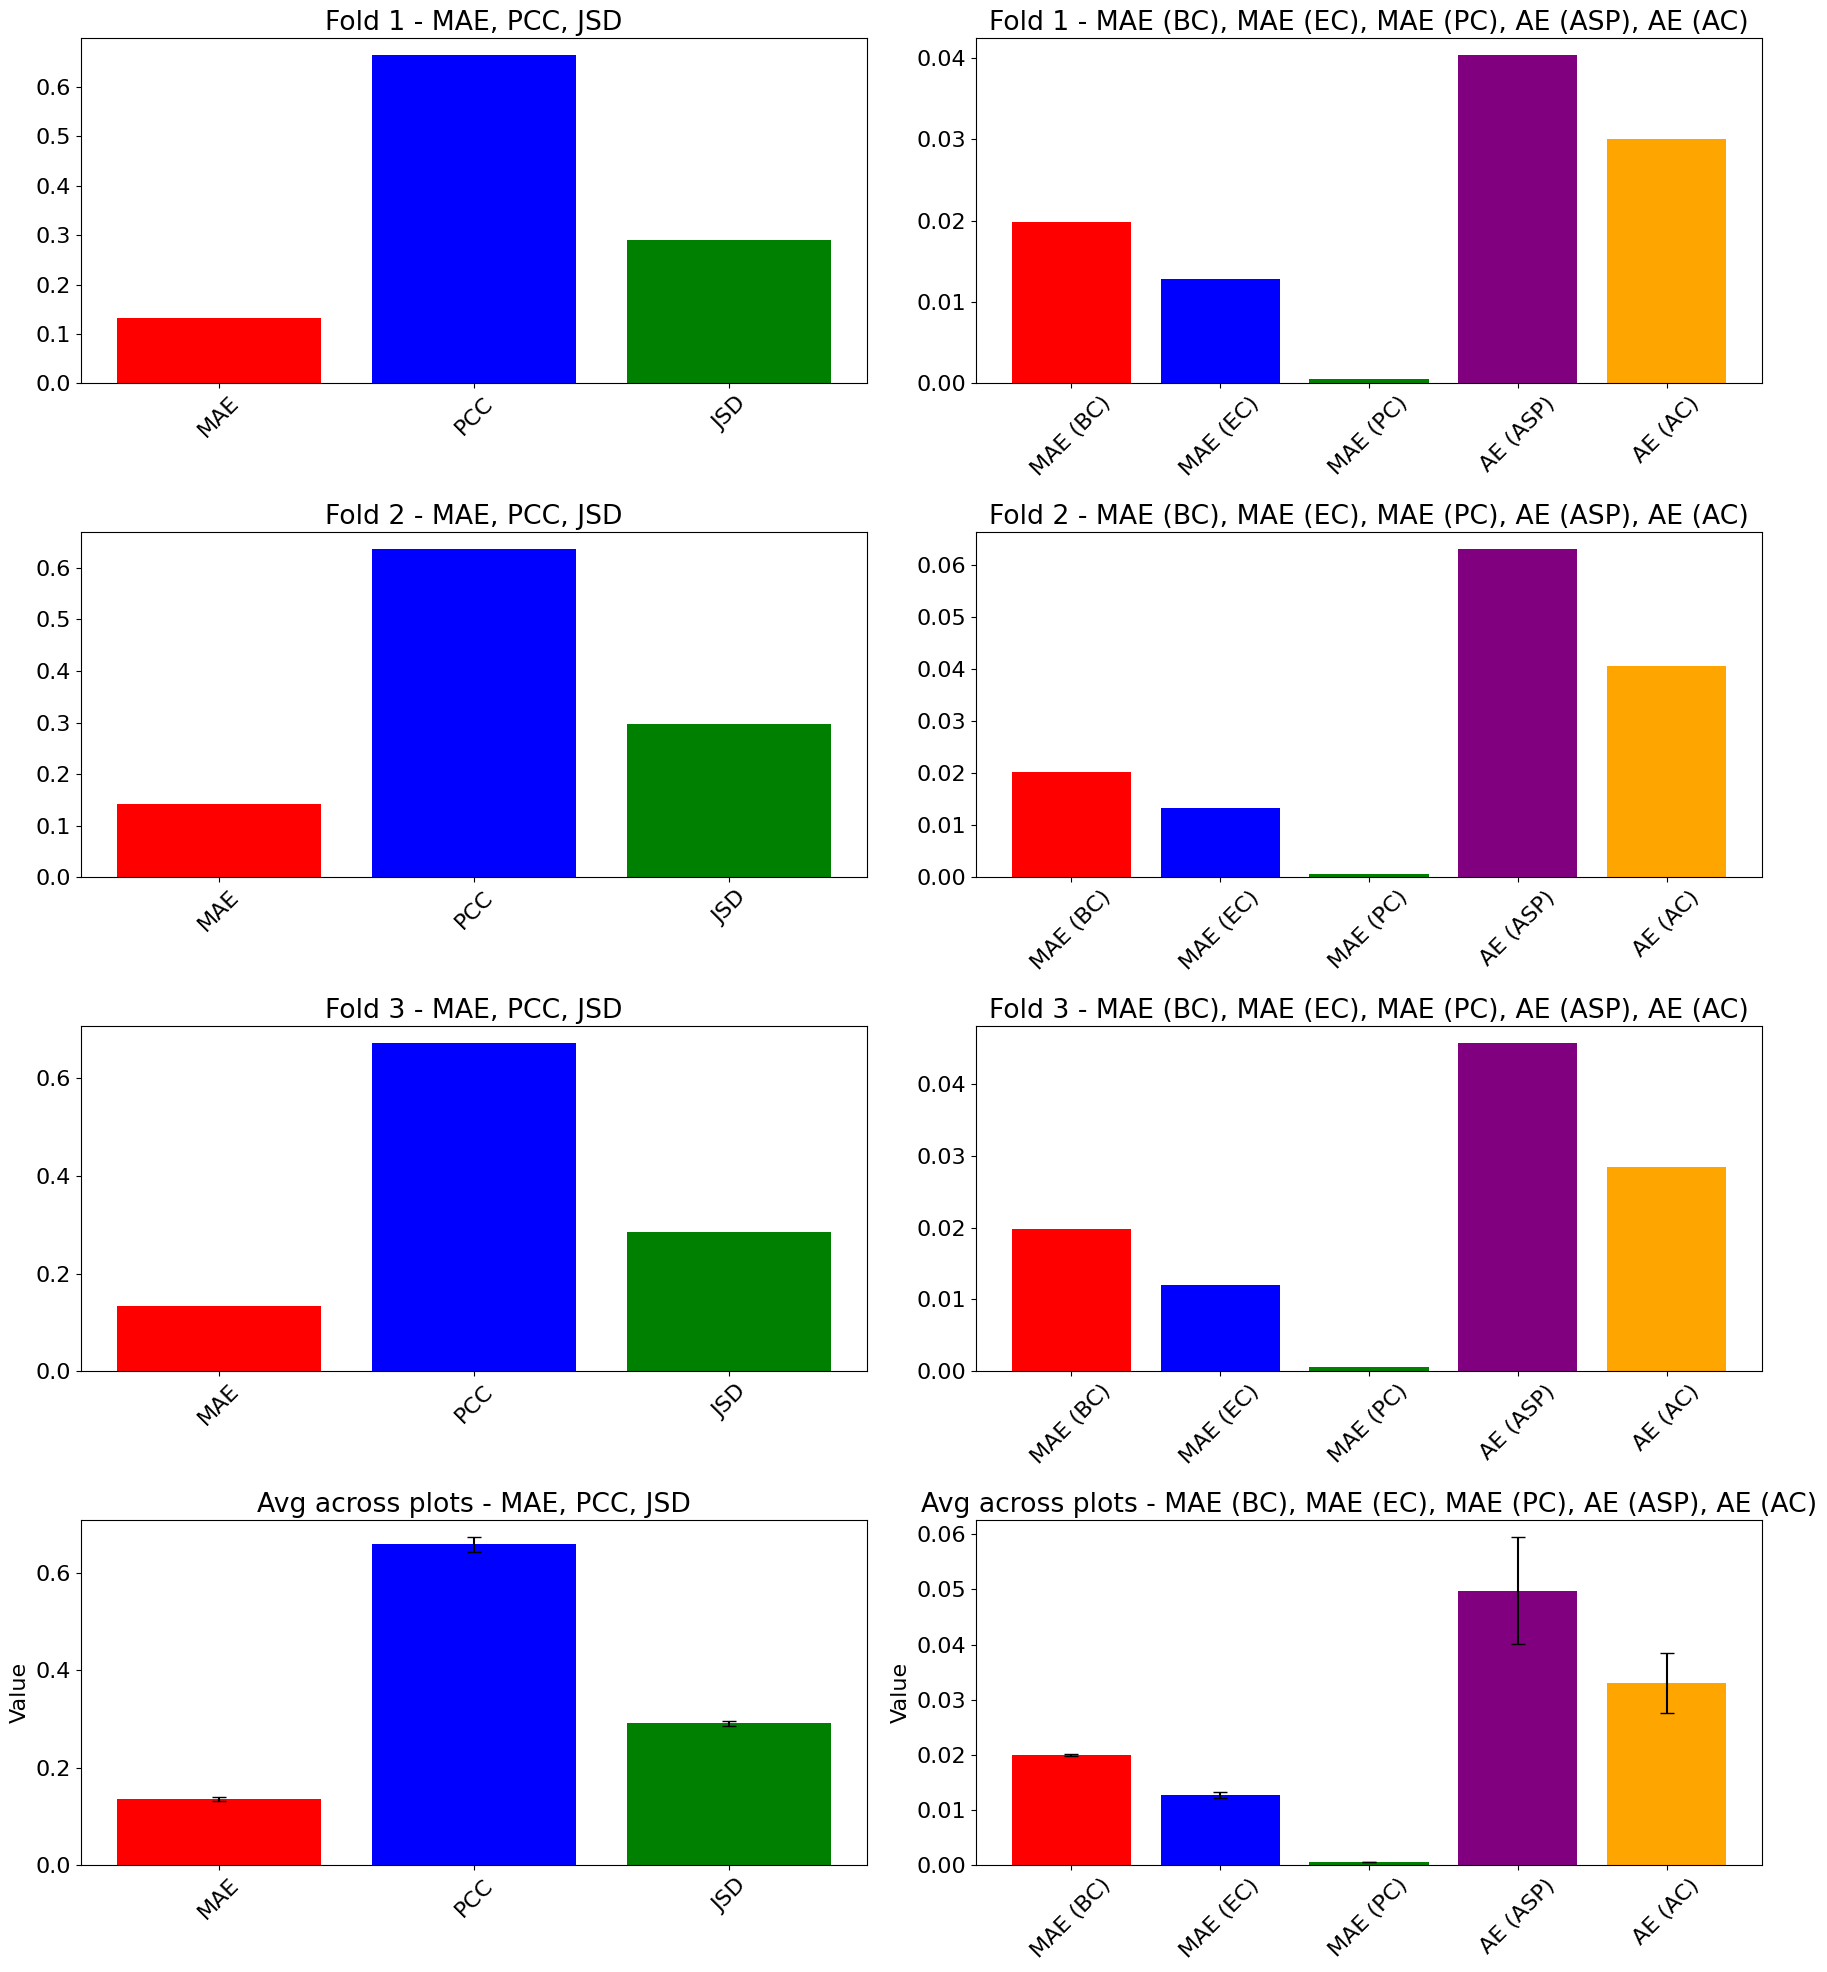

In [8]:
# Sample data: Three lists, each with tuples of length 8
# Compute means and standard deviations
data_array = np.array(all_metrics)  
plt.rcParams.update({'font.size': 16})

# Number of categories
categories = ["MAE", "PCC", "JSD", "MAE (BC)", "MAE (EC)", "MAE (PC)", "AE (ASP)", "AE (AC)"]
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "cyan"]
x = np.arange(len(categories))
slice1 = slice(0, 3)
slice2 = slice(3, 8)

# Plot individual bar graphs for each tuple
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

axes[0, 0].bar(x[:3], data_array[0][slice1], color=colors)
axes[0, 0].set_title(f"Fold 1 - MAE, PCC, JSD")
axes[0, 0].set_xticks(x[:3])
axes[0, 0].set_xticklabels(categories[:3], rotation=45)

axes[0, 1].bar(x[3:], data_array[0][slice2], color=colors)
axes[0, 1].set_title(f"Fold 1 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[0, 1].set_xticks(x[3:])
axes[0, 1].set_xticklabels(categories[3:], rotation=45)

axes[1, 0].bar(x[:3], data_array[1][slice1], color=colors)
axes[1, 0].set_title(f"Fold 2 - MAE, PCC, JSD")
axes[1, 0].set_xticks(x[:3])
axes[1, 0].set_xticklabels(categories[:3], rotation=45)

axes[1, 1].bar(x[3:], data_array[1][slice2], color=colors)
axes[1, 1].set_title(f"Fold 2 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[1, 1].set_xticks(x[3:])
axes[1, 1].set_xticklabels(categories[3:], rotation=45)

axes[2, 0].bar(x[:3], data_array[2][slice1], color=colors)
axes[2, 0].set_title(f"Fold 3 - MAE, PCC, JSD")
axes[2, 0].set_xticks(x[:3])
axes[2, 0].set_xticklabels(categories[:3], rotation=45)

axes[2, 1].bar(x[3:], data_array[2][slice2], color=colors)
axes[2, 1].set_title(f"Fold 3 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[2, 1].set_xticks(x[3:])
axes[2, 1].set_xticklabels(categories[3:], rotation=45)

# Compute the average and standard deviation across the three tuples for each category
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)

# Plot the average bar graph with error bars for the standard deviation
axes[3, 0].bar(x[:3], mean_values[:3], yerr=std_values[:3], capsize=5, color=colors)
axes[3, 0].set_title("Avg across plots - MAE, PCC, JSD")
axes[3, 0].set_xticks(x[:3])
axes[3, 0].set_xticklabels(categories[:3], rotation=45)
axes[3, 0].set_ylabel("Value")

axes[3, 1].bar(x[3:], mean_values[3:], yerr=std_values[3:], capsize=5, color=colors)
axes[3, 1].set_title("Avg across plots - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[3, 1].set_xticks(x[3:])
axes[3, 1].set_xticklabels(categories[3:], rotation=45)
axes[3, 1].set_ylabel("Value")
plt.tight_layout()
plt.show()